In [23]:
import pandas as pd
import numpy as np
import sqlite3
import json
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
from os.path import expanduser
%matplotlib inline

In [3]:
EXPERIMENT_NAME = 'P3830'

#### prepare the TFD/E results

In [5]:
# load the results
EXPERIMENT_DIR = '/media/data-4t-a/results-P3830_YUPS1/2021-10-10-01-59-26'

RESULTS_DB_NAME = '{}/summarised-results/results.sqlite'.format(EXPERIMENT_DIR)
db_conn = sqlite3.connect(RESULTS_DB_NAME)
results_yups1_df = pd.read_sql_query("select * from sequences", db_conn)
db_conn.close()

In [6]:
# load the results
EXPERIMENT_DIR = '/media/data-4t-a/results-P3830_YUPS2/2021-10-11-12-21-21'

RESULTS_DB_NAME = '{}/summarised-results/results.sqlite'.format(EXPERIMENT_DIR)
db_conn = sqlite3.connect(RESULTS_DB_NAME)
results_yups2_df = pd.read_sql_query("select * from sequences", db_conn)
db_conn.close()

In [7]:
results_df = pd.concat([results_yups1_df,results_yups2_df], axis=0, sort=False, ignore_index=True)

In [8]:
len(results_df)

24247

In [9]:
# convert the identifications from JSON to Python objects
results_df['identifications_d'] = results_df.apply(lambda row: json.loads(row.identifications), axis=1)

In [10]:
def classify_protein(protein):
    result = 'UNKNOWN'
    if 'HUMAN' in protein.upper():
        result = 'HUMAN'
    elif 'YEAST' in protein.upper():
        result = 'YEAST'
    elif 'ECOLI' in protein.upper():
        result = 'E.COLI'
    return result

In [11]:
# separate some key metrics into separate columns
results_df['id_perc_q_value'] = results_df.apply(lambda row: row.identifications_d['perc_q_value'], axis=1)
results_df['id_count_all_runs'] = results_df.apply(lambda row: len(row.identifications_d['run_names']), axis=1)
results_df['id_count_human_only_runs'] = results_df.apply(lambda row: sum('YHE010' in s for s in row.identifications_d['run_names']), axis=1)
results_df['id_number_of_proteins'] = results_df.apply(lambda row: row.identifications_d['number_of_proteins'], axis=1)

In [12]:
results_df['id_protein'] = results_df.apply(lambda row: row.identifications_d['proteins'][0], axis=1)
results_df['id_species'] = results_df.apply(lambda row: classify_protein(row.id_protein), axis=1)

In [13]:
results_df.id_species.unique()

array(['YEAST', 'HUMAN'], dtype=object)

In [14]:
# remove the results that couldn't be extracted or were not classified as a target
results_df = results_df[results_df.extractions.notnull()].copy()

In [15]:
# convert from JSON to Python objects
results_df['extractions_l'] = results_df.apply(lambda row: json.loads(row.extractions), axis=1)

In [16]:
# separate some key metrics into separate columns
results_df['ext_count_all_runs'] = results_df.apply(lambda row: len(row.extractions_l), axis=1)
results_df['ext_count_human_only_runs'] = results_df.apply(lambda row: sum('YHE010' in s['run_name'] for s in row.extractions_l), axis=1)

In [17]:
results_df.sample(n=3)

,sequence,charge,identifications,extractions,identifications_d,id_perc_q_value,id_count_all_runs,id_count_human_only_runs,id_number_of_proteins,id_protein,id_species,extractions_l,ext_count_all_runs,ext_count_human_only_runs
19651,NEFSEEDGDHNGEFSGK,2,"{""perc_q_value"": 0.00020790453, ""run_names"": [...","[{""run_name"": ""P3830_YeastUPS2_01_Slot1-1_1_50...","{'perc_q_value': 0.00020790453, 'run_names': [...",0.000208,10,0,1,sp|P33892|GCN1_YEAST,YEAST,[{'run_name': 'P3830_YeastUPS2_01_Slot1-1_1_50...,10,0
4320,HLQDGTGWSTFEYGYMK,2,"{""perc_q_value"": 0.0083513603, ""run_names"": [""...","[{""run_name"": ""P3830_YeastUPS1_01_Slot1-1_1_50...","{'perc_q_value': 0.0083513603, 'run_names': ['...",0.008351,1,0,1,sp|Q08873|SCP1_YEAST,YEAST,[{'run_name': 'P3830_YeastUPS1_01_Slot1-1_1_50...,10,0
16480,HEIASEVASFLNGNIIEHDVPEHFFGELAK,3,"{""perc_q_value"": 0.00027022506, ""run_names"": [...","[{""run_name"": ""P3830_YeastUPS2_01_Slot1-1_1_50...","{'perc_q_value': 0.00027022506, 'run_names': [...",0.000270,10,0,1,sp|P16521|EF3A_YEAST,YEAST,[{'run_name': 'P3830_YeastUPS2_01_Slot1-1_1_50...,10,0


In [18]:
results_df.iloc[0].identifications

'{"perc_q_value": 0.0022427383, "run_names": ["P3830_YeastUPS1_05_Slot1-1_1_5070", "P3830_YeastUPS1_06_Slot1-1_1_5076", "P3830_YeastUPS1_09_Slot1-1_1_5079"], "number_of_runs": 3, "proteins": ["sp|P00925|ENO2_YEAST"], "number_of_proteins": 1}'

In [19]:
# count the number of unique peptide identifications in each run
counts_d = {}
for row in results_df.itertuples():
    for run_name in row.identifications_d['run_names']:
        if run_name not in counts_d:
            counts_d[run_name] = 0
        counts_d[run_name] += 1

In [20]:
# sort the run names by group then run number within the group
sorted_counts_l = []
for k in sorted(list(counts_d.keys()), key=lambda x: ( x.split('_')[1], int(x.split('_')[2]) )):
    short_run_name = '_'.join(k.split('_Slot')[0].split('_')[1:])
    sorted_counts_l.append((short_run_name, counts_d[k]))
sorted_counts_df = pd.DataFrame(sorted_counts_l, columns=['run_name','count'])

#### prepare the MaxQuant results

In [26]:
mq_results_df = pd.read_csv('{}/MQ-analysis-of-P3830/combined/txt/evidence.txt'.format(expanduser('~')), sep='\\t', engine='python')

In [27]:
# remove decoys, which are indicated by a '+' in the Reverse column
mq_results_df = mq_results_df[pd.isna(mq_results_df.Reverse)]
# remove identifications with no intensity
mq_results_df = mq_results_df[(mq_results_df.Intensity > 0)]
# remove potential contaminants
mq_results_df = mq_results_df[pd.isna(mq_results_df['Potential contaminant'])]
# remove identifications with mass error more than +/- 5 ppm
mq_results_df = mq_results_df[np.abs(mq_results_df['Mass error [ppm]']) <= 5.0]

In [28]:
# definition of uniqueness in MaxQuant output with MBR on
unique_peptide_key = ['Sequence','Modifications','Charge']

In [29]:
# count the number of unique peptide identifications in each run
mq_counts_d = {}
for group_name,group_df in mq_results_df.groupby(unique_peptide_key, as_index=False):
    df = group_df[(group_df.Type == 'TIMS-MULTI-MSMS')]
    for run_name in df['Raw file'].unique():
        if run_name not in mq_counts_d:
            mq_counts_d[run_name] = 0
        mq_counts_d[run_name] += 1

In [30]:
mq_sorted_counts_l = []
for k in sorted(mq_counts_d.keys()):
    short_run_name = '_'.join(k.split('_Slot')[0].split('_')[1:3])
    mq_sorted_counts_l.append((short_run_name, mq_counts_d[k]))
mq_sorted_counts_df = pd.DataFrame(mq_sorted_counts_l, columns=['run_name','count'])

#### prepare the MSFragger results

In [32]:
# use the Fragger analysis without MBR because there doesn't seem to be a way of distinguishing between identification and matching
fragger_results_df = pd.read_csv('{}/MSFragger-analysis-P3830/P3830-results/MSstats.csv'.format(expanduser('~')), sep=',')


In [33]:
fragger_results_df = fragger_results_df[fragger_results_df.Intensity.notnull()]

In [34]:
fragger_results_df.sample(n=5)

,ProteinName,PeptideSequence,PrecursorCharge,FragmentIon,ProductCharge,IsotopeLabelType,Condition,BioReplicate,Run,Intensity
80308,sp|P19882|HSP60_YEAST,KISSIQDILPALEISNQSR,2,NaN,NaN,L,YUPS1,9,P3830_YeastUPS1_09_Slot1-1_1_5079,44758.430
193344,sp|P40856|SA185_YEAST,FLLDDLLINIR,2,NaN,NaN,L,YUPS1,5,P3830_YeastUPS1_05_Slot1-1_1_5070,4327.990
71557,sp|P16861|PFKA1_YEAST,TGIHFGC[57.0215]DVFAVYEGYEGLLR,2,NaN,NaN,L,YUPS2,8,P3830_YeastUPS2_08_Slot1-1_1_5089,28659.080
202793,sp|P43621|COPD_YEAST,INDHDLSHSNLK,2,NaN,NaN,L,YUPS2,4,P3830_YeastUPS2_04_Slot1-1_1_5085,9702.542
174699,sp|P39104|PIK1_YEAST,VPYLLLIEYLR,2,NaN,NaN,L,YUPS2,10,P3830_YeastUPS2_10_Slot1-1_1_5091,12933.977


In [35]:
# count the number of unique peptide identifications in each run
fragger_counts_d = {}
for group_name,group_df in fragger_results_df.groupby(['PeptideSequence', 'PrecursorCharge'], as_index=False):
    for run_name in group_df['Run'].unique():
        if run_name not in fragger_counts_d:
            fragger_counts_d[run_name] = 0
        fragger_counts_d[run_name] += 1

In [36]:
# sort the run names by group then run number within the group
sorted_counts_l = []
for k in sorted(list(fragger_counts_d.keys()), key=lambda x: ( x.split('_')[1], int(x.split('_')[2]) )):
    short_run_name = '_'.join(k.split('_Slot')[0].split('_')[1:])
    sorted_counts_l.append((short_run_name, fragger_counts_d[k]))
fragger_sorted_counts_df = pd.DataFrame(sorted_counts_l, columns=['run_name','count'])

#### plot the unique peptide level

In [37]:
merged_df = sorted_counts_df.merge(mq_sorted_counts_df,on='run_name').merge(fragger_sorted_counts_df,on='run_name')
merged_df.rename({'count_x':'count_tfd/e', 'count_y':'count_mq', 'count':'count_fragger'}, axis=1, inplace=True)
merged_df.index = merged_df.run_name

In [38]:
merged_df.sample(n=3)

,run_name,count_tfd/e,count_mq,count_fragger
run_name,,,,
YeastUPS1_10,YeastUPS1_10,7331,5911,10161
YeastUPS1_03,YeastUPS1_03,8190,6530,10866
YeastUPS1_01,YeastUPS1_01,8072,6565,10868


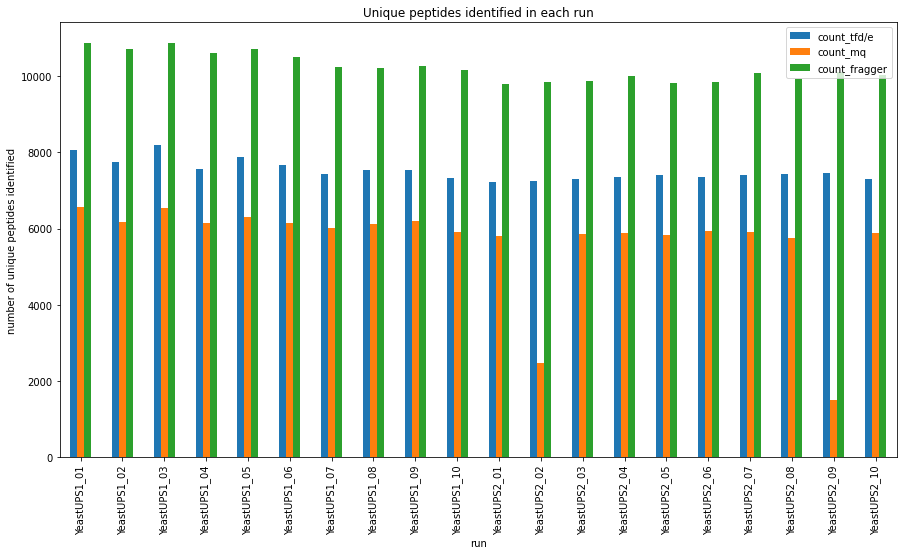

In [39]:
merged_df.plot(kind='bar', figsize=(15,8))
_ = plt.title("Unique peptides identified in each run")
_ = plt.xlabel("run")
_ = plt.ylabel("number of unique peptides identified")

## missing-ness heatmaps

In [40]:
# return True if we can include an extraction from the specified group, given the groups in which it was identified
# need to implement these rules differently for each experiment, probably best with a simple rules parameter file
def extract_from_group(extract_group, identification_run_names_l):
    return True

#### prepare the TFD/E data

In [41]:
# gather the lower intensity decile
results_df.columns

Index(['sequence', 'charge', 'identifications', 'extractions',
       'identifications_d', 'id_perc_q_value', 'id_count_all_runs',
       'id_count_human_only_runs', 'id_number_of_proteins', 'id_protein',
       'id_species', 'extractions_l', 'ext_count_all_runs',
       'ext_count_human_only_runs'],
      dtype='object')

In [42]:
sequences_l = []
for row in results_df.itertuples():
    for group_name in ['YeastUPS1','YeastUPS2']:
        if extract_from_group(extract_group=group_name, identification_run_names_l=row.identifications_d['run_names']):
            for extraction in row.extractions_l:
                if group_name in extraction['run_name']:
                    short_run_name = '_'.join(extraction['run_name'].split('_Slot')[0].split('_')[1:3])
                    identified_in_run = extraction['run_name'] in row.identifications_d['run_names']
                    sequences_l.append((row.sequence, row.charge, row.id_perc_q_value, row.id_protein, row.id_species, short_run_name, group_name, extraction['intensity'], identified_in_run))
sequences_df = pd.DataFrame(sequences_l, columns=['sequence', 'charge', 'id_perc_q_value', 'protein', 'species', 'short_run_name', 'group','intensity','identified_in_run'])


In [43]:
# find the mean intensity for each peptide in each group
intensities_l = []
for group_name,group_df in sequences_df.groupby(['sequence','charge','group'], as_index=False):
    mean_intensity = group_df.intensity.mean()
    intensities_l.append((group_name[0], group_name[1], group_name[2], mean_intensity))
intensities_df = pd.DataFrame(intensities_l, columns=['sequence', 'charge', 'group', 'group_mean_intensity'])

In [44]:
# sort each group by descending intensity
intensities_df.sort_values(by=['group_mean_intensity'], ascending=False, inplace=True)

In [45]:
intensities_df.tail()

,sequence,charge,group,group_mean_intensity
19712,TGTLTTSETAHNM[15.9949]K,2,YeastUPS1,63.333333
15043,NSAALHQAVPK,2,YeastUPS1,47.000000
15520,QDASPKPYAVK,2,YeastUPS2,46.000000
7344,GVAMNPVDHPHGGGNHQHIGK,3,YeastUPS1,45.000000
2885,DQEGDDEDGNTATGHGVK,2,YeastUPS1,30.500000


In [46]:
# make a separate DF for each group
YeastUPS1_df = intensities_df[(intensities_df.group == 'YeastUPS1')].copy()
YeastUPS2_df = intensities_df[(intensities_df.group == 'YeastUPS2')].copy()

In [47]:
# find the lowest-intensity peptides in each group
lower_number = 500
YeastUPS1_lowest_df = YeastUPS1_df.tail(lower_number)
YeastUPS2_lowest_df = YeastUPS2_df.tail(lower_number)

## TFD/E heatmaps

#### plot YeastUPS1

In [48]:
YeastUPS1_df.tail(n=5)

,sequence,charge,group,group_mean_intensity
1758,CLDHGTTEQCDNLCDK,2,YeastUPS1,71.000000
19712,TGTLTTSETAHNM[15.9949]K,2,YeastUPS1,63.333333
15043,NSAALHQAVPK,2,YeastUPS1,47.000000
7344,GVAMNPVDHPHGGGNHQHIGK,3,YeastUPS1,45.000000
2885,DQEGDDEDGNTATGHGVK,2,YeastUPS1,30.500000


In [49]:
run_names_l = sorted(list(sequences_df[sequences_df.group == 'YeastUPS1'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [50]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in YeastUPS1_lowest_df.itertuples():
    run_occurences_df = sequences_df[(sequences_df.sequence == row.sequence) & (sequences_df.charge == row.charge) & (sequences_df.group == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

In [51]:
occurences_df.tail(n=10)

,YeastUPS1_01,YeastUPS1_02,YeastUPS1_03,YeastUPS1_04,YeastUPS1_05,YeastUPS1_06,YeastUPS1_07,YeastUPS1_08,YeastUPS1_09,YeastUPS1_10
"Q[-17.0265]LELAHLEHSLK,2",0.000000,0.000000,0.0,0.000000,0.000000,6.357552,0.0,0.000000,0.000000,0.000000
"FKEEDEKESQR,2",0.000000,0.000000,0.0,0.000000,6.426265,0.000000,0.0,0.000000,6.507795,5.977280
"NQAALNPR,1",0.000000,0.000000,0.0,6.475733,0.000000,6.000000,0.0,0.000000,0.000000,0.000000
"KVVITAPSSTAPMFVMGVNEEK,3",0.000000,0.000000,0.0,6.523562,0.000000,0.000000,0.0,5.857981,0.000000,0.000000
"IATYQER,1",6.149747,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
"CLDHGTTEQCDNLCDK,2",0.000000,0.000000,0.0,0.000000,6.149747,0.000000,0.0,0.000000,0.000000,0.000000
"TGTLTTSETAHNM[15.9949]K,2",0.000000,6.321928,0.0,5.672425,0.000000,0.000000,0.0,5.882643,0.000000,0.000000
"NSAALHQAVPK,2",0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,5.554589,0.000000,0.000000
"GVAMNPVDHPHGGGNHQHIGK,3",0.000000,0.000000,0.0,0.000000,3.169925,0.000000,0.0,6.339850,0.000000,0.000000
"DQEGDDEDGNTATGHGVK,2",0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,3.321928,0.000000,5.672425


Text(0.5, 1.0, 'Lowest 500 peptides by mean intensity for YeastUPS1 by TFD/E')

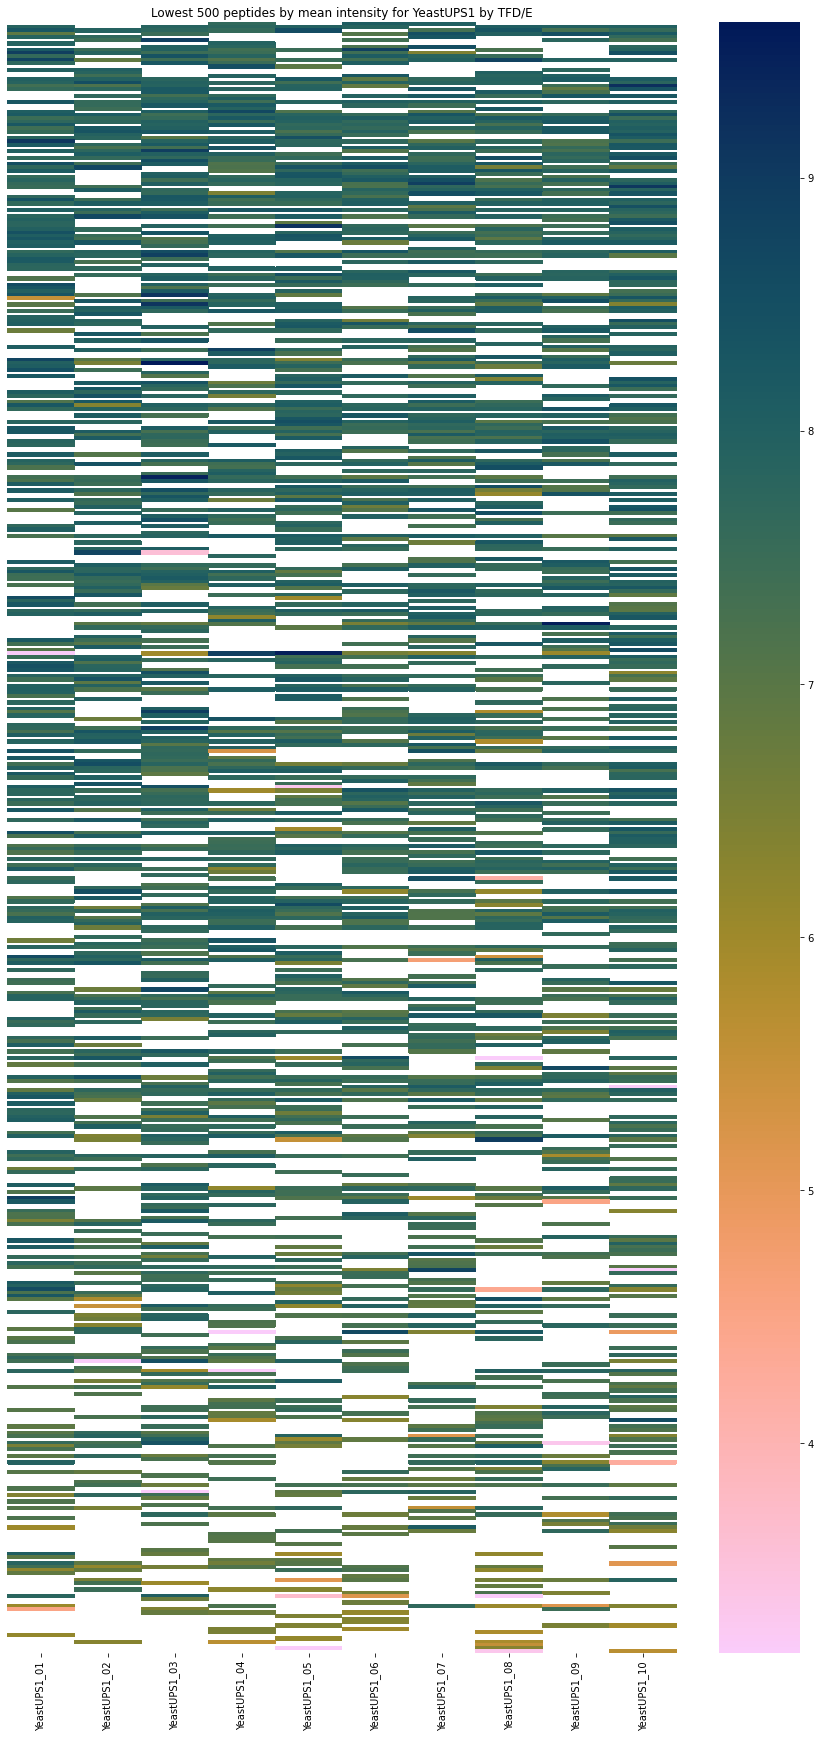

In [52]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap=cm.batlow_r, vmin=a[a > 0].min(), vmax=a.max(), mask=(occurences_df==0), linewidths=0)
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
plt.title('Lowest {} peptides by mean intensity for YeastUPS1 by TFD/E'.format(lower_number))

#### plot YeastUPS2

In [53]:
run_names_l = sorted(list(sequences_df[sequences_df.group == 'YeastUPS2'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [54]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in YeastUPS2_lowest_df.itertuples():
    run_occurences_df = sequences_df[(sequences_df.sequence == row.sequence) & (sequences_df.charge == row.charge) & (sequences_df.group == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

Text(0.5, 1.0, 'Lowest 500 peptides by mean intensity for YeastUPS2 by TFD/E')

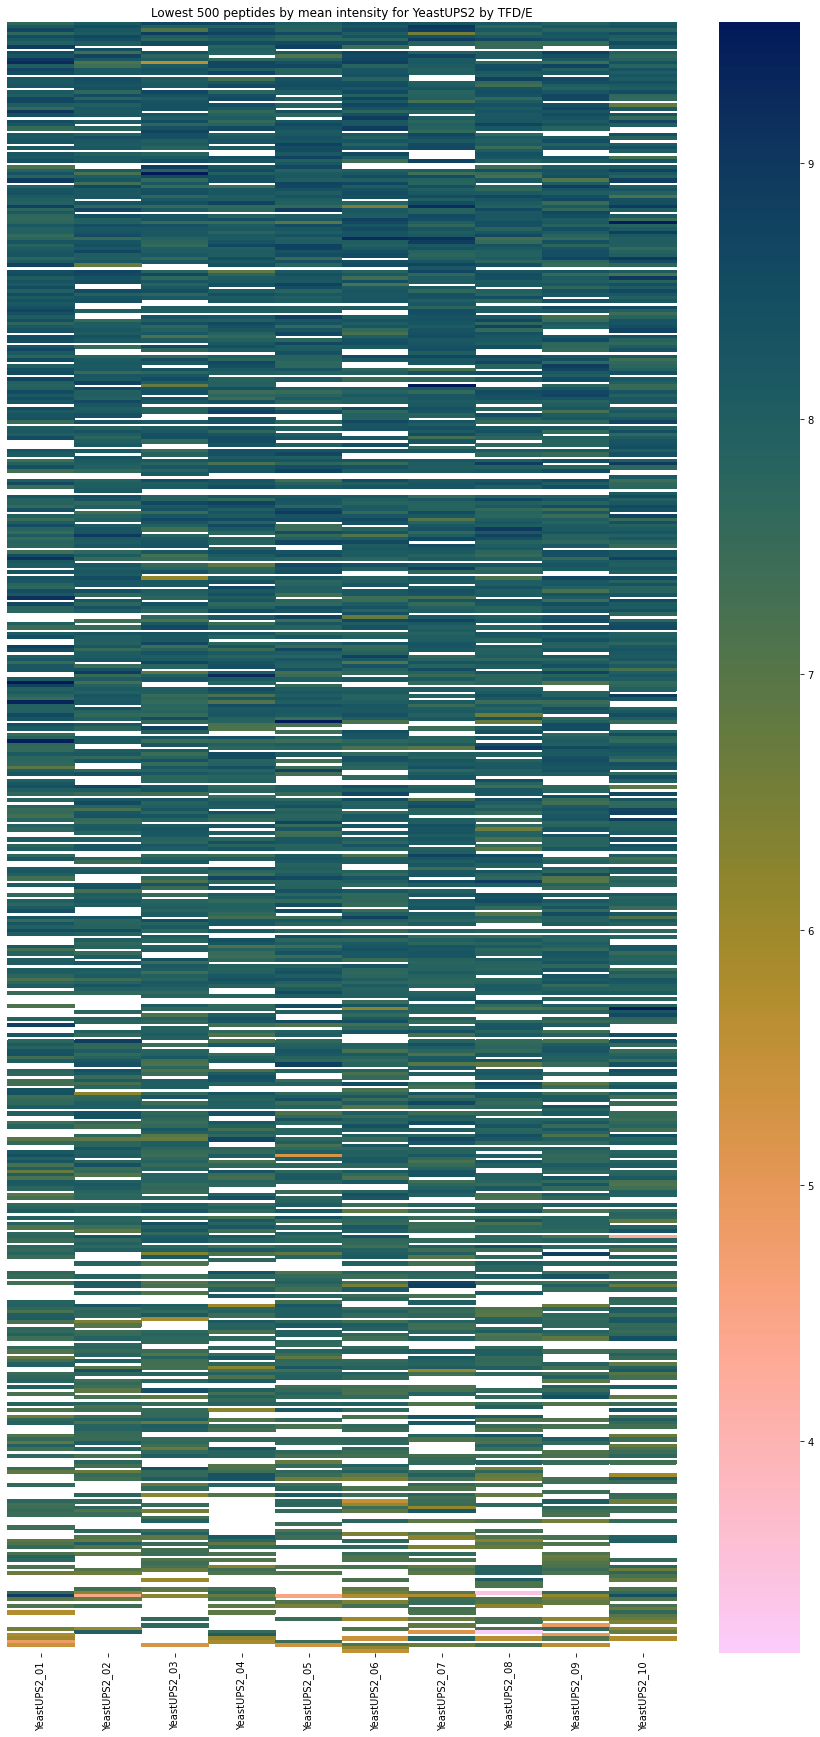

In [55]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap=cm.batlow_r, vmin=a[a > 0].min(), vmax=a.max(), mask=(occurences_df==0), linewidths=0)
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
plt.title('Lowest {} peptides by mean intensity for YeastUPS2 by TFD/E'.format(lower_number))

## MaxQuant heatmaps

In [56]:
mq_results_df.columns

Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages',
       'Proteins', 'Leading proteins', 'Leading razor protein', 'Type',
       'Raw file', 'MS/MS m/z', 'Charge', 'm/z', 'Mass',
       'Uncalibrated - Calibrated m/z [ppm]',
       'Uncalibrated - Calibrated m/z [Da]', 'Mass error [ppm]',
       'Mass error [Da]', 'Uncalibrated mass error [ppm]',
       'Uncalibrated mass error [Da]', 'Max intensity m/z 0', 'Retention time',
       'Retention length', 'Calibrated retention time',
       'Calibrated retention time start', 'Calibrated retention time finish',
       'Retention time calibration', 'Ion mobility index',
       'Ion mobility length', '1/K0', '1/K0 length', 'Calibrated 1/K0', 'CCS',
       'Calibrated CCS', 'CCS length', 'Match time difference',
       'Match m/z difference', 'Match K0 difference', 'Match q-value',
       'M

In [57]:
mq_results_df.iloc[1466].Proteins

'sp|P53207|SNU71_YEAST'

In [58]:
# get one reading for each unique peptide in each run, and count how many identifications and extractions (i.e. 
# matches) across each group. Note that a sequence can be counted as an identification and a match in the same file 
# (i.e. it's given a different score).
mq_sequences_l = []
unique_peptide_key_file = unique_peptide_key + ['Raw file']
for group_name,group_df in mq_results_df.groupby(unique_peptide_key_file, as_index=False):
    identified_in_file = (len(group_df[group_df.Type == 'TIMS-MULTI-MSMS']) > 0)
    short_run_name = '_'.join(group_name[3].split('_Slot')[0].split('_')[1:3])
    grp_name = short_run_name.split('_')[0]
    sorted_df = group_df.sort_values(by=['Intensity'], ascending=False, inplace=False)
    if identified_in_file:
        score = sorted_df.iloc[0]['Score']
    else:
        score = sorted_df.iloc[0]['Match score']
    intensity = sorted_df.iloc[0].Intensity
    protein = sorted_df.iloc[0].Proteins
    species = classify_protein(protein)
    mq_sequences_l.append((group_name[0], group_name[1], group_name[2], species, short_run_name, grp_name, identified_in_file, score, intensity))
mq_sequences_df = pd.DataFrame(mq_sequences_l, columns=['sequence','modifications','charge','species','short_run_name','group','identified_in_file','score','intensity'])


In [59]:
mq_sequences_df.sample(n=5)

,sequence,modifications,charge,species,short_run_name,group,identified_in_file,score,intensity
116434,SNVSSGMNAVDPSVYTDTSSK,Unmodified,2,YEAST,YeastUPS1_04,YeastUPS1,True,103.630,202540.0
62543,ITQVSGVTPIVHYISDR,Unmodified,2,YEAST,YeastUPS1_04,YeastUPS1,False,180.480,23686.0
39983,GEDASYETVHDATGINCK,Unmodified,2,YEAST,YeastUPS1_05,YeastUPS1,True,109.470,17092.0
50979,HLNDIEPCVFDK,Unmodified,2,YEAST,YeastUPS1_10,YeastUPS1,True,78.043,49392.0
101733,QAVVNPENTLFATK,Unmodified,2,YEAST,YeastUPS2_10,YeastUPS2,True,123.920,304340.0


In [60]:
# find the mean intensity for each peptide in each group
mq_intensities_l = []
for group_name,group_df in mq_sequences_df.groupby(['sequence','modifications','charge','group'], as_index=False):
    mean_intensity = group_df.intensity.mean()
    mq_intensities_l.append((group_name[0], group_name[1], group_name[2], group_name[3], mean_intensity))
mq_intensities_df = pd.DataFrame(mq_intensities_l, columns=['sequence', 'modifications', 'charge', 'group', 'group_mean_intensity'])

In [61]:
# sort each group by descending intensity
mq_intensities_df.sort_values(by=['group_mean_intensity'], ascending=False, inplace=True)

In [62]:
mq_intensities_df.tail()

,sequence,modifications,charge,group,group_mean_intensity
15327,SSGSTPIYSLNHDQPVENVIAVSPTQIVSCGGNNFK,Unmodified,3,YeastUPS1,1241.5
16941,TTALELLTVFSENAPQMCK,Unmodified,2,YeastUPS1,1239.3
19589,YYNDVILHK,Unmodified,2,YeastUPS2,1236.5
13623,QTEIAQHIFTK,Unmodified,2,YeastUPS2,1204.5
11257,MPLVGLGCWK,Unmodified,2,YeastUPS1,1198.5


In [63]:
# make a separate DF for each group
YeastUPS1_df = mq_intensities_df[(mq_intensities_df.group == 'YeastUPS1')].copy()
YeastUPS2_df = mq_intensities_df[(mq_intensities_df.group == 'YeastUPS2')].copy()

In [64]:
# find the lowest-intensity peptides in each group
lower_number = 500
YeastUPS1_lowest_df = YeastUPS1_df.tail(lower_number)
YeastUPS2_lowest_df = YeastUPS2_df.tail(lower_number)

#### plot YeastUPS1

In [65]:
run_names_l = sorted(list(mq_sequences_df[mq_sequences_df.group == 'YeastUPS1'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [66]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in YeastUPS1_lowest_df.itertuples():
    run_occurences_df = mq_sequences_df[(mq_sequences_df.sequence == row.sequence) & (mq_sequences_df.modifications == row.modifications) & (mq_sequences_df.charge == row.charge) & (mq_sequences_df.group == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

Text(0.5, 1.0, 'Lowest 500 peptides by mean intensity for YeastUPS1 by MaxQuant')

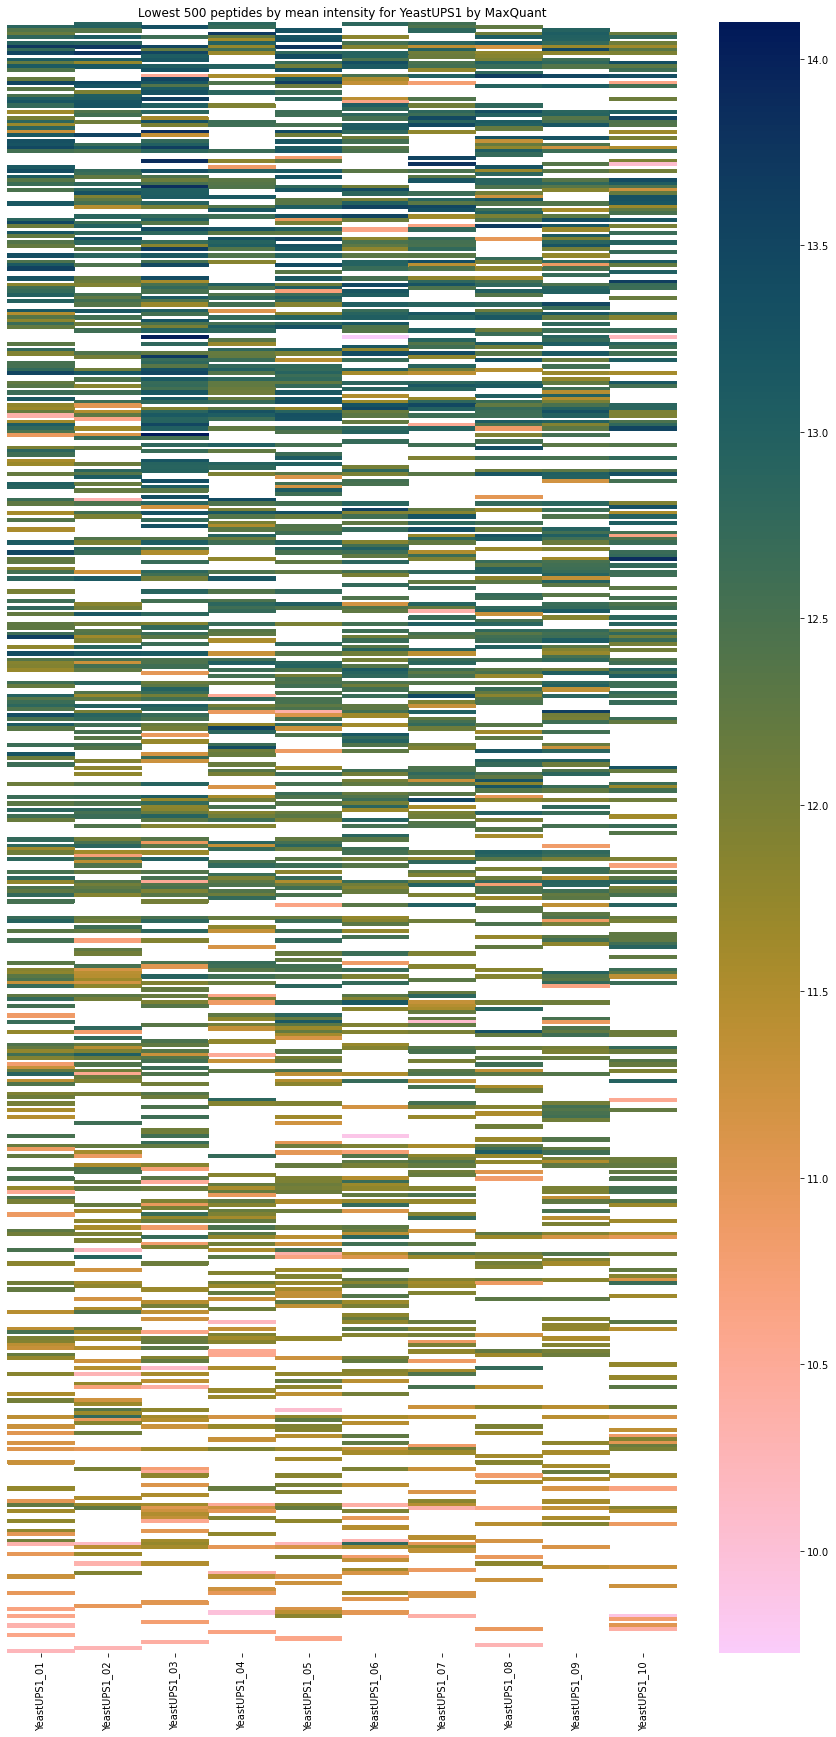

In [67]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap=cm.batlow_r, vmin=a[a > 0].min(), vmax=a.max(), mask=(occurences_df==0), linewidths=0)
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
plt.title('Lowest {} peptides by mean intensity for YeastUPS1 by MaxQuant'.format(lower_number))


#### plot YeastUPS2

In [68]:
run_names_l = sorted(list(mq_sequences_df[mq_sequences_df.group == 'YeastUPS2'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [69]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in YeastUPS2_lowest_df.itertuples():
    run_occurences_df = mq_sequences_df[(mq_sequences_df.sequence == row.sequence) & (mq_sequences_df.modifications == row.modifications) & (mq_sequences_df.charge == row.charge) & (mq_sequences_df.group == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

Text(0.5, 1.0, 'Lowest 500 peptides by mean intensity for YeastUPS2 by MaxQuant')

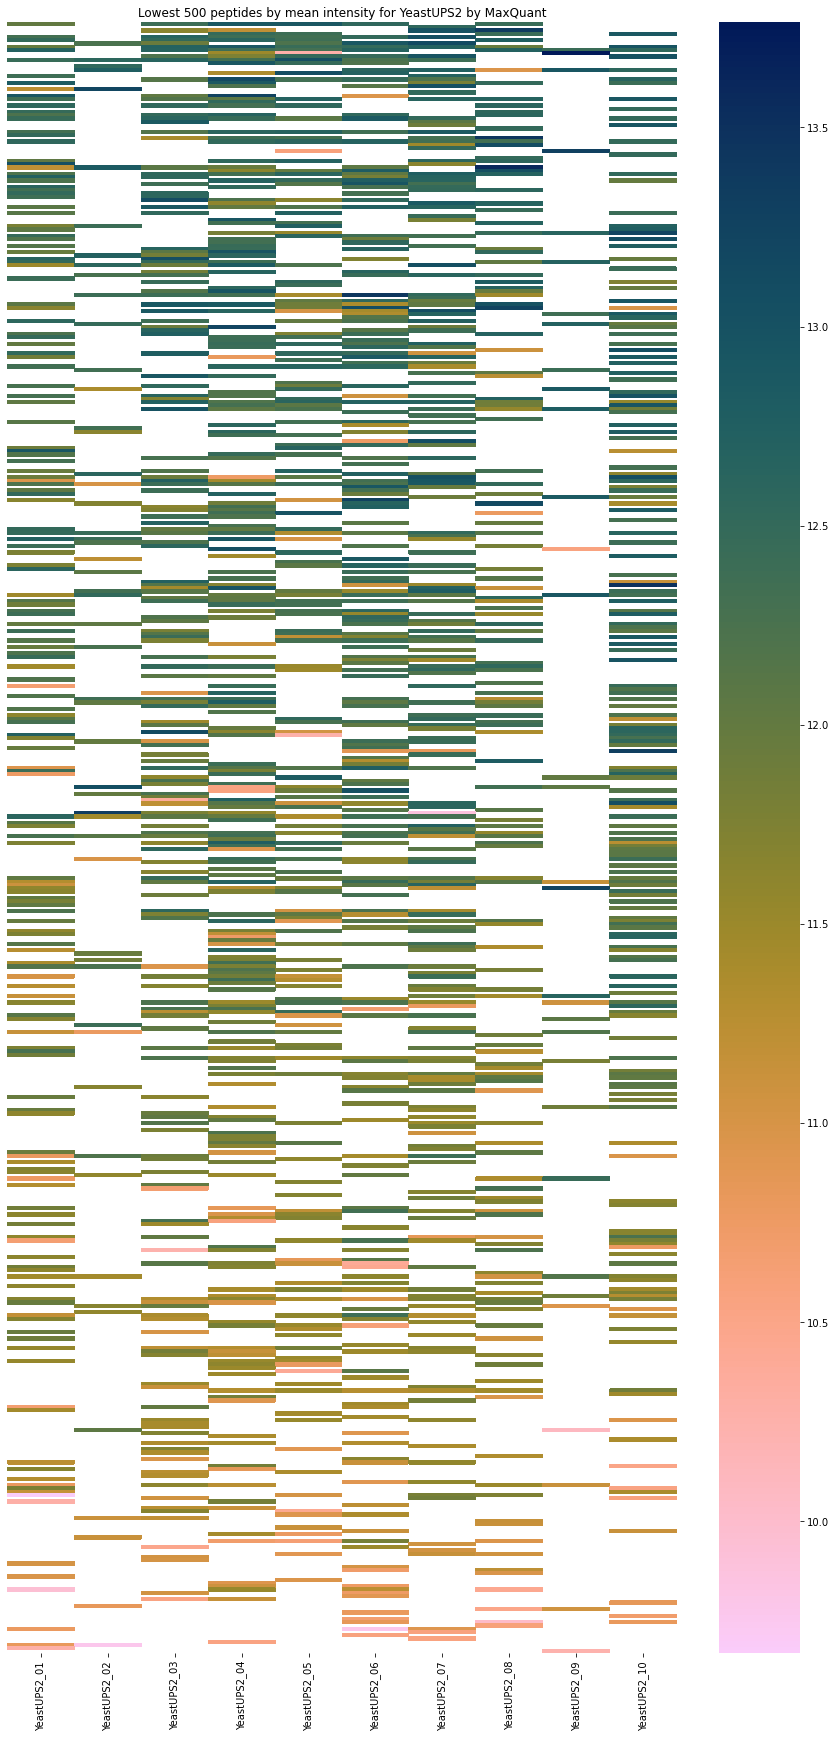

In [70]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap=cm.batlow_r, vmin=a[a > 0].min(), vmax=a.max(), mask=(occurences_df==0), linewidths=0)
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
plt.title('Lowest {} peptides by mean intensity for YeastUPS2 by MaxQuant'.format(lower_number))

## Fragger heatmaps

In [72]:
# use the analysis with MBR
fragger_results_df = pd.read_csv('{}/MSFragger-analysis-P3830/P3830-results/MSstats.csv'.format(expanduser('~')), sep=',')

In [73]:
fragger_sequences_df = fragger_results_df.copy()
fragger_sequences_df.columns

Index(['ProteinName', 'PeptideSequence', 'PrecursorCharge', 'FragmentIon',
       'ProductCharge', 'IsotopeLabelType', 'Condition', 'BioReplicate', 'Run',
       'Intensity'],
      dtype='object')

In [74]:
condition_mapping_d = {'YUPS1':'YeastUPS1', 'YUPS2':'YeastUPS2'}

In [75]:
fragger_sequences_df['short_run_name'] = fragger_sequences_df.apply(lambda row: '_'.join(row.Run.split('_Slot')[0].split('_')[1:3]), axis=1)
fragger_sequences_df['group'] = fragger_sequences_df.apply(lambda row: condition_mapping_d[row.Condition], axis=1)

In [76]:
fragger_sequences_df['species'] = fragger_sequences_df.apply(lambda row: classify_protein(row.ProteinName), axis=1)

In [77]:
fragger_sequences_df = fragger_sequences_df[fragger_sequences_df.Intensity.notnull()]
fragger_sequences_df = fragger_sequences_df[fragger_sequences_df.Intensity > 0]

In [78]:
fragger_sequences_df.sample(n=3)

,ProteinName,PeptideSequence,PrecursorCharge,FragmentIon,ProductCharge,IsotopeLabelType,Condition,BioReplicate,Run,Intensity,short_run_name,group,species
271433,sp|Q07878|VPS13_YEAST,VDFAQRPDSFLSSFQLNK,2,NaN,NaN,L,YUPS2,4,P3830_YeastUPS2_04_Slot1-1_1_5085,33967.035,YeastUPS2_04,YeastUPS2,YEAST
29734,sp|P06634|DED1_YEAST,GLDIPNVTHVINYDLPSDVDDYVHR,3,NaN,NaN,L,YUPS2,5,P3830_YeastUPS2_05_Slot1-1_1_5086,42174.500,YeastUPS2_05,YeastUPS2,YEAST
280963,sp|Q12160|YP063_YEAST,APSPMDQPPAIK,2,NaN,NaN,L,YUPS1,4,P3830_YeastUPS1_04_Slot1-1_1_5069,9705.753,YeastUPS1_04,YeastUPS1,YEAST


In [79]:
# find the mean intensity for each peptide in each group
fragger_intensities_l = []
for group_name,group_df in fragger_sequences_df.groupby(['PeptideSequence','PrecursorCharge','group'], as_index=False):
    mean_intensity = group_df.Intensity.mean()
    fragger_intensities_l.append((group_name[0], group_name[1], group_name[2], mean_intensity))
fragger_intensities_df = pd.DataFrame(fragger_intensities_l, columns=['sequence', 'charge', 'group', 'group_mean_intensity'])

In [80]:
# sort each group by descending intensity
fragger_intensities_df.sort_values(by=['group_mean_intensity'], ascending=False, inplace=True)

In [81]:
fragger_intensities_df.tail()

,sequence,charge,group,group_mean_intensity
7817,GSGWNGSDAVHTNMTNTR,2,YeastUPS2,199.496485
7036,GFLDENDILSLYGLNR,2,YeastUPS2,166.179000
18982,SISYNPSQHSVLVNEANGK,2,YeastUPS1,158.717500
4677,ELQGIDPDETVPDNVK,2,YeastUPS2,152.408000
13103,LGNGISSEQLLDK,2,YeastUPS1,113.255490


In [82]:
# make a separate DF for each group
YeastUPS1_df = fragger_intensities_df[(fragger_intensities_df.group == 'YeastUPS1')].copy()
YeastUPS2_df = fragger_intensities_df[(fragger_intensities_df.group == 'YeastUPS2')].copy()

In [83]:
# find the lowest-intensity peptides in each group
lower_number = 500
YeastUPS1_lowest_df = YeastUPS1_df.tail(lower_number)
YeastUPS2_lowest_df = YeastUPS2_df.tail(lower_number)

#### plot YeastUPS1

In [84]:
run_names_l = sorted(list(fragger_sequences_df[fragger_sequences_df.group == 'YeastUPS1'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [85]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in YeastUPS1_lowest_df.itertuples():
    run_occurences_df = fragger_sequences_df[(fragger_sequences_df.PeptideSequence == row.sequence) & (fragger_sequences_df.PrecursorCharge == row.charge) & (fragger_sequences_df.group == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.Intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

Text(0.5, 1.0, 'Lowest 500 peptides by mean intensity for YeastUPS1 by MSFragger')

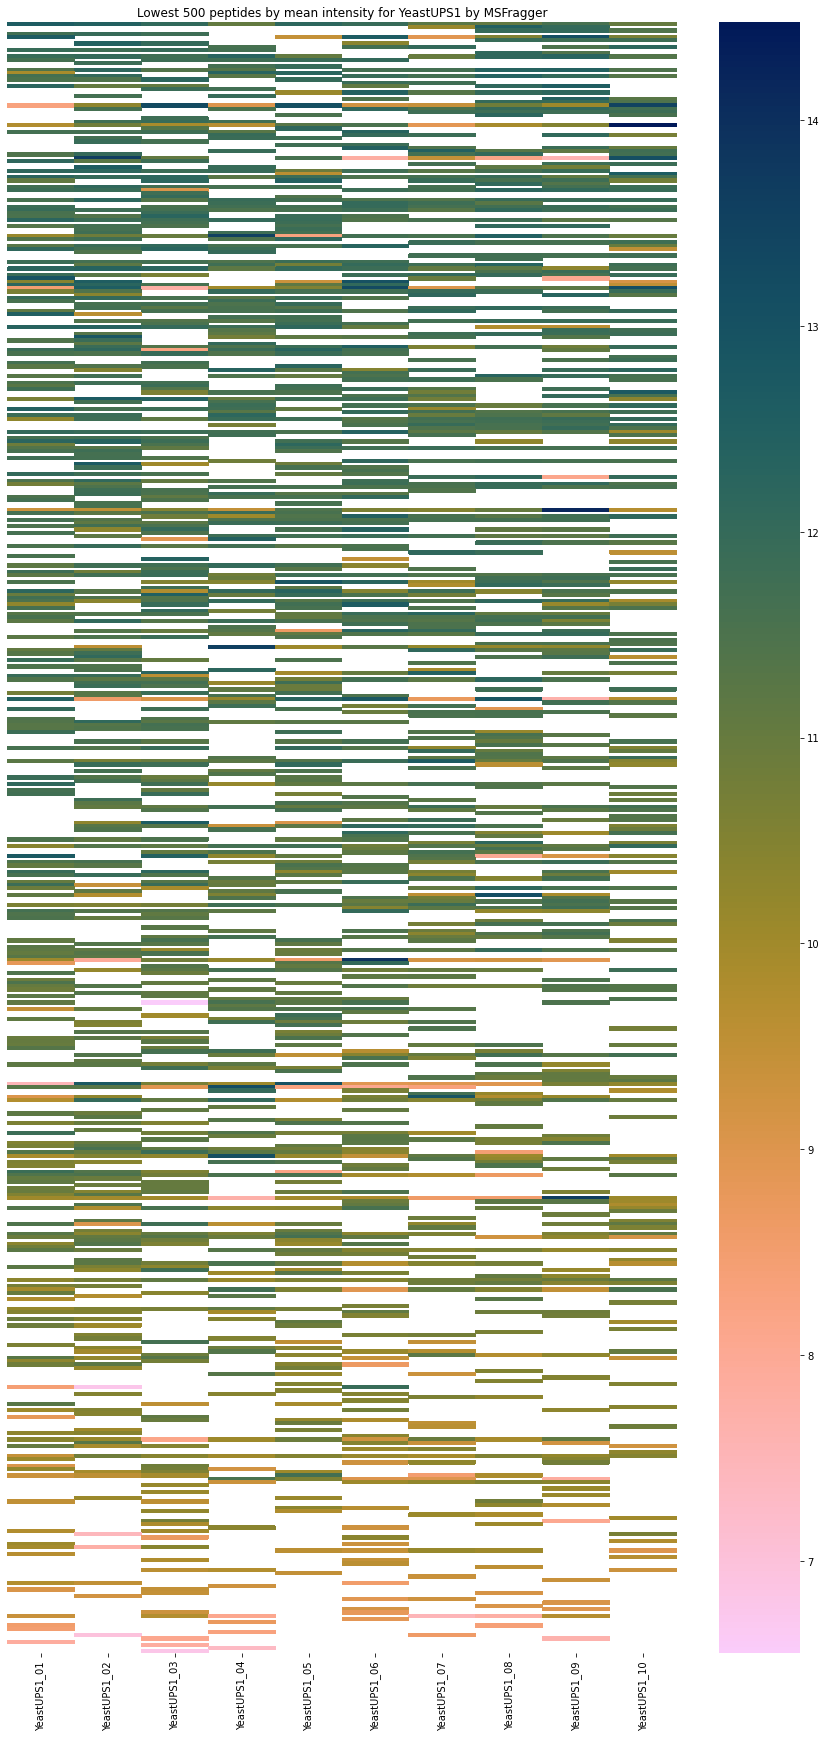

In [86]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap=cm.batlow_r, vmin=a[a > 0].min(), vmax=a.max(), mask=(occurences_df==0), linewidths=0)
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
plt.title('Lowest {} peptides by mean intensity for YeastUPS1 by MSFragger'.format(lower_number))

#### plot YeastUPS2

In [87]:
run_names_l = sorted(list(fragger_sequences_df[fragger_sequences_df.group == 'YeastUPS2'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [88]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in YeastUPS2_lowest_df.itertuples():
    run_occurences_df = fragger_sequences_df[(fragger_sequences_df.PeptideSequence == row.sequence) & (fragger_sequences_df.PrecursorCharge == row.charge) & (fragger_sequences_df.group == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.Intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

Text(0.5, 1.0, 'Lowest 500 peptides by intensity for YeastUPS2 by MSFragger')

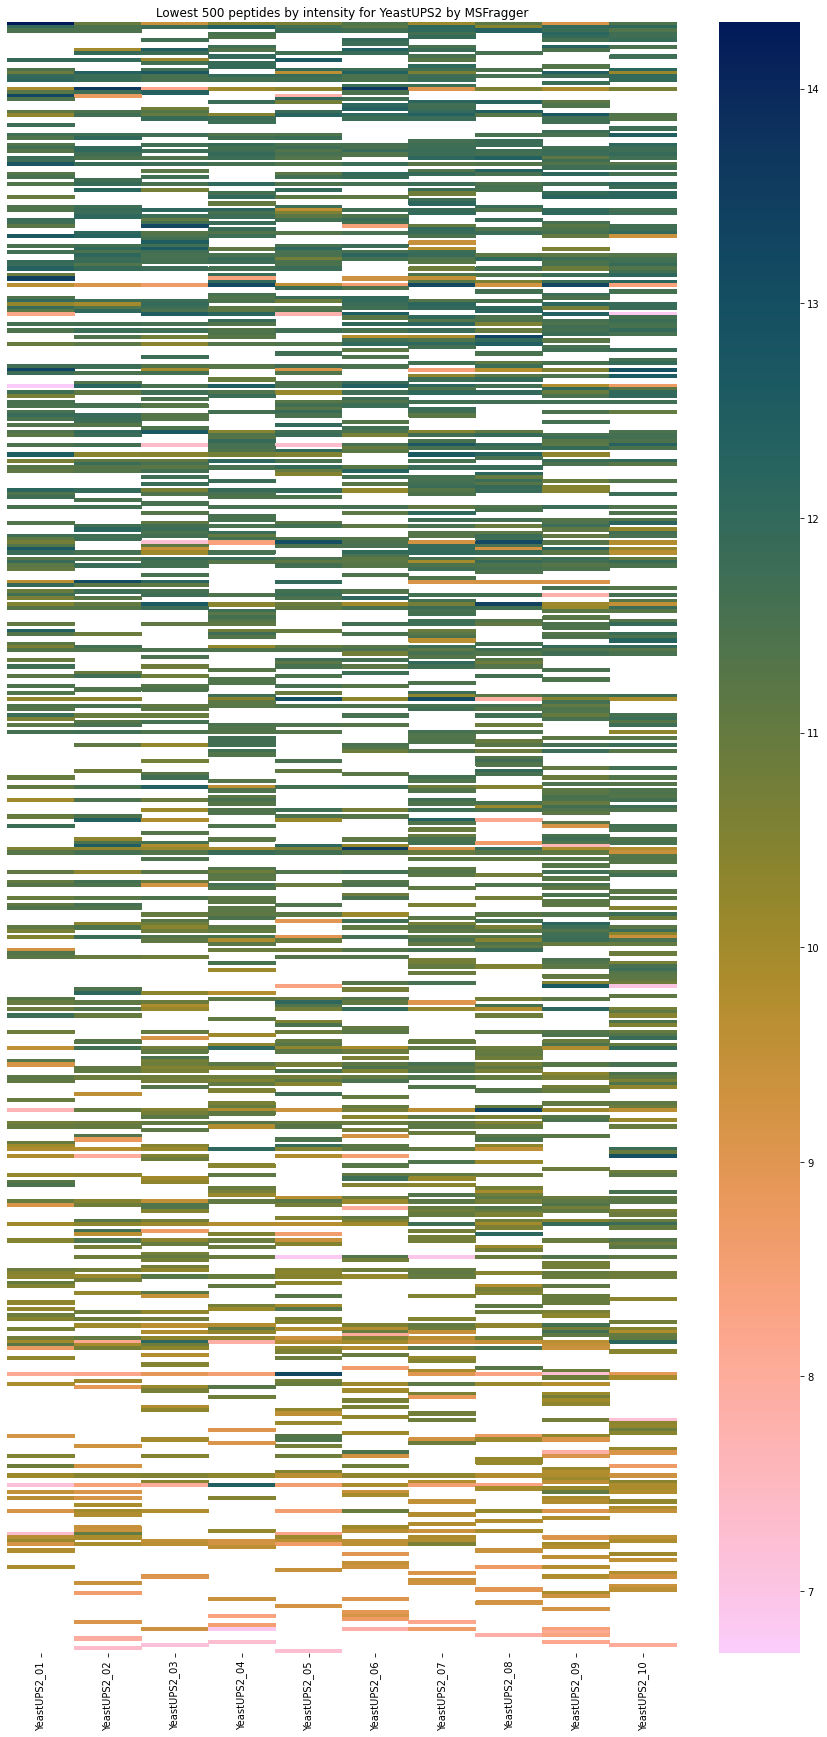

In [89]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap=cm.batlow_r, vmin=a[a > 0].min(), vmax=a.max(), mask=(occurences_df==0), linewidths=0)
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
plt.title('Lowest {} peptides by intensity for YeastUPS2 by MSFragger'.format(lower_number))

## visualise the percentage of missing values across runs

#### prepare TFD/E results

In [90]:
subset_groups = ['YeastUPS1']

In [91]:
tfde_subset_df = sequences_df[(sequences_df.group.isin(subset_groups))]

In [92]:
number_of_runs_in_subset = len(tfde_subset_df.short_run_name.unique())
print('there are {} {} runs in the experiment'.format(number_of_runs_in_subset, subset_groups))

there are 10 ['YeastUPS1'] runs in the experiment


In [93]:
number_of_unique_sequences_tfde = len(tfde_subset_df.drop_duplicates(subset=['sequence', 'charge'], keep='first', inplace=False))
number_of_unique_sequences_tfde

12478

In [94]:
# count how many runs each sequence/charge was extracted from and classified as a target
sequence_occurences_l = []
for group_name,group_df in tfde_subset_df.groupby(['sequence','charge'], as_index=False):
    sequence_occurences_l.append((group_name, len(group_df.short_run_name.unique()), group_name[0], group_name[1]))
tfde_sequence_occurences_df = pd.DataFrame(sequence_occurences_l, columns=['sequence_charge','number_of_runs_extracted','sequence','charge'])

In [95]:
tfde_sequence_occurences_df['missing_files'] = number_of_runs_in_subset - tfde_sequence_occurences_df.number_of_runs_extracted

In [96]:
# display the number of missing values across the subset
tfde_missing_values = tfde_sequence_occurences_df.missing_files.sum() / (len(tfde_sequence_occurences_df) * number_of_runs_in_subset)

In [97]:
tfde_sequence_occurences_df.sample(n=3)

,sequence_charge,number_of_runs_extracted,sequence,charge,missing_files
6601,"(LLTEIVQITGWEQLLK, 2)",10,LLTEIVQITGWEQLLK,2,0
5260,"(IWHHTFYNELR, 2)",10,IWHHTFYNELR,2,0
6827,"(LQSMAVEHK, 2)",2,LQSMAVEHK,2,8


In [98]:
run_count_l = []
for number_of_runs in range(1,number_of_runs_in_subset+1):
    run_count_l.append((number_of_runs, len(tfde_sequence_occurences_df[tfde_sequence_occurences_df.number_of_runs_extracted >= number_of_runs])))
tfde_run_count_df = pd.DataFrame(run_count_l, columns=['run_count','number_of_sequences'])

In [99]:
tfde_run_count_df['percent_quantified'] = tfde_run_count_df.number_of_sequences / number_of_unique_sequences_tfde * 100

#### prepare MQ results

In [100]:
mq_sequences_df.columns

Index(['sequence', 'modifications', 'charge', 'species', 'short_run_name',
       'group', 'identified_in_file', 'score', 'intensity'],
      dtype='object')

In [101]:
mq_subset_df = mq_sequences_df[(mq_sequences_df.group.isin(subset_groups))]

In [102]:
number_of_unique_sequences_mq = len(mq_subset_df.drop_duplicates(subset=['sequence','modifications','charge'], keep='first', inplace=False))
number_of_unique_sequences_mq

10068

In [103]:
# count how many runs each sequence/charge was extracted from
sequence_occurences_l = []
for group_name,group_df in mq_subset_df.groupby(['sequence', 'modifications', 'charge'], as_index=False):
    sequence_occurences_l.append((group_name[0], group_name[1], group_name[2], len(group_df.short_run_name.unique())))
mq_sequence_occurences_df = pd.DataFrame(sequence_occurences_l, columns=['sequence','modifications','charge','number_of_runs_extracted'])

In [104]:
run_count_l = []
for number_of_runs in range(1,number_of_runs_in_subset+1):
    run_count_l.append((number_of_runs, len(mq_sequence_occurences_df[mq_sequence_occurences_df.number_of_runs_extracted >= number_of_runs])))
mq_run_count_df = pd.DataFrame(run_count_l, columns=['run_count','number_of_sequences'])

In [105]:
mq_sequence_occurences_df['missing_files'] = number_of_runs_in_subset - mq_sequence_occurences_df.number_of_runs_extracted
mq_run_count_df['percent_quantified'] = mq_run_count_df.number_of_sequences / number_of_unique_sequences_mq * 100

In [106]:
# display the number of missing values across the subset
mq_missing_values = mq_sequence_occurences_df.missing_files.sum() / (len(mq_sequence_occurences_df) * number_of_runs_in_subset)

#### prepare Fragger results

In [107]:
fragger_subset_df = fragger_sequences_df[(fragger_sequences_df.group.isin(subset_groups))]

In [108]:
number_of_unique_sequences_fragger = len(fragger_subset_df.drop_duplicates(subset=['PeptideSequence', 'PrecursorCharge'], keep='first', inplace=False))
number_of_unique_sequences_fragger

13456

In [109]:
# count how many runs each sequence/charge was found in
sequence_occurences_l = []
for group_name,group_df in fragger_subset_df.groupby(['PeptideSequence','PrecursorCharge'], as_index=False):
    sequence_occurences_l.append((group_name[0], group_name[1], len(group_df.short_run_name.unique())))
fragger_sequence_occurences_df = pd.DataFrame(sequence_occurences_l, columns=['sequence','charge','number_of_runs_extracted'])

In [110]:
run_count_l = []
for number_of_runs in range(1,number_of_runs_in_subset+1):
    run_count_l.append((number_of_runs, len(fragger_sequence_occurences_df[fragger_sequence_occurences_df.number_of_runs_extracted >= number_of_runs])))
fragger_run_count_df = pd.DataFrame(run_count_l, columns=['run_count','number_of_sequences'])

In [111]:
fragger_sequence_occurences_df['missing_files'] = number_of_runs_in_subset - fragger_sequence_occurences_df.number_of_runs_extracted
fragger_run_count_df['percent_quantified'] = fragger_run_count_df.number_of_sequences / number_of_unique_sequences_fragger * 100

In [112]:
# display the number of missing values across the subset
fragger_missing_values = fragger_sequence_occurences_df.missing_files.sum() / (len(fragger_sequence_occurences_df) * number_of_runs_in_subset)

#### now plot the results

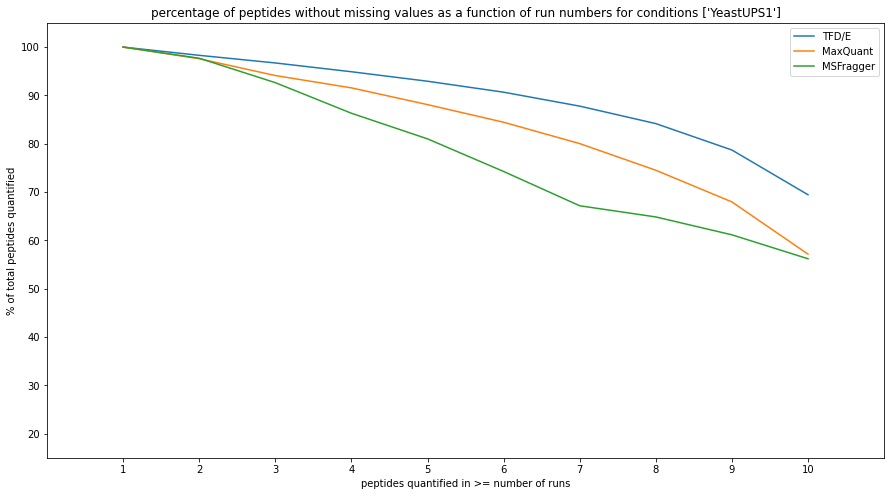

In [113]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('percentage of peptides without missing values as a function of run numbers for conditions {}'.format(subset_groups))

ax1.plot(tfde_run_count_df.run_count, tfde_run_count_df.percent_quantified, label='TFD/E')
ax1.plot(mq_run_count_df.run_count, mq_run_count_df.percent_quantified, label='MaxQuant')
ax1.plot(fragger_run_count_df.run_count, fragger_run_count_df.percent_quantified, label='MSFragger')

plt.xlabel('peptides quantified in >= number of runs')
plt.ylabel('% of total peptides quantified')
plt.ylim((15,105))
ax1.set(xticks=range(1,number_of_runs_in_subset+1), xlim=[0, number_of_runs_in_subset+1])
plt.legend(loc="best")

plt.show()

## missing-ness distributions

#### plot TFD/E results

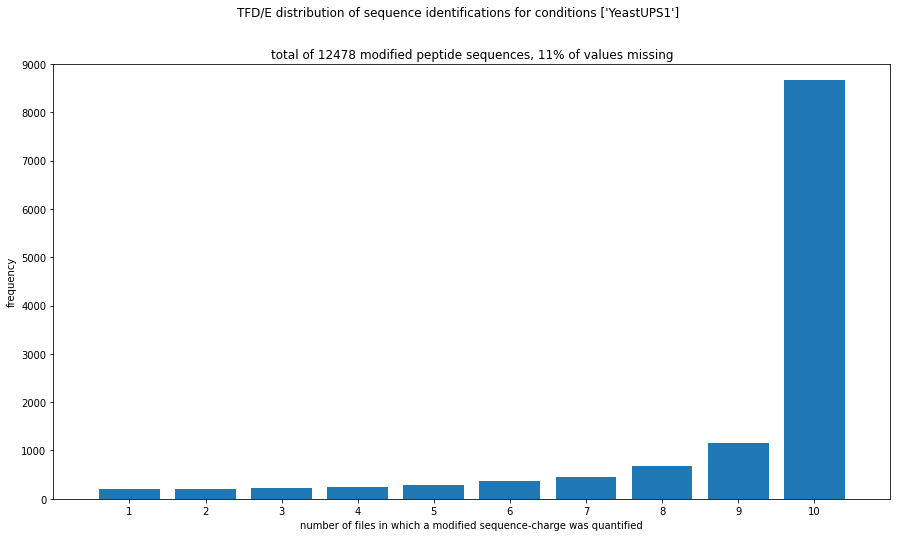

In [114]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.suptitle('TFD/E distribution of sequence identifications for conditions {}'.format(subset_groups))
plt.title('total of {} modified peptide sequences, {}% of values missing'.format(number_of_unique_sequences_tfde, int(round(tfde_missing_values*100))))

counts = np.bincount(tfde_sequence_occurences_df.number_of_runs_extracted)
ax1.bar(range(number_of_runs_in_subset+1), counts, width=0.8, align='center')
plt.xlabel('number of files in which a modified sequence-charge was quantified')
plt.ylabel('frequency')
ax1.set(xticks=range(1,number_of_runs_in_subset+1), xlim=[0, number_of_runs_in_subset+1])
plt.ylim((0,9000))

plt.show()

#### plot MQ results

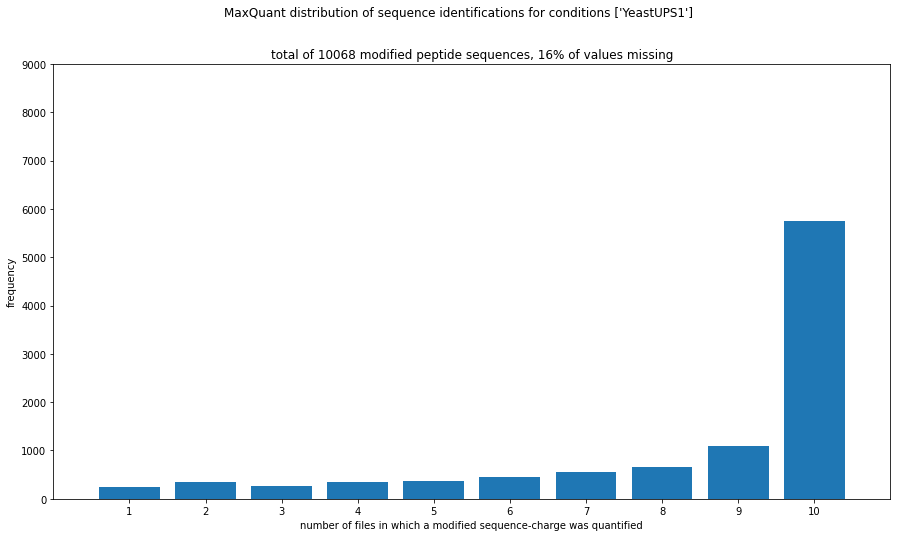

In [115]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.suptitle('MaxQuant distribution of sequence identifications for conditions {}'.format(subset_groups))
plt.title('total of {} modified peptide sequences, {}% of values missing'.format(number_of_unique_sequences_mq, int(round(mq_missing_values*100))))

counts = np.bincount(mq_sequence_occurences_df.number_of_runs_extracted)
ax1.bar(range(number_of_runs_in_subset+1), counts, width=0.8, align='center')
plt.xlabel('number of files in which a modified sequence-charge was quantified')
plt.ylabel('frequency')
ax1.set(xticks=range(1,number_of_runs_in_subset+1), xlim=[0, number_of_runs_in_subset+1])
plt.ylim((0,9000))

plt.show()

#### plot Fragger results

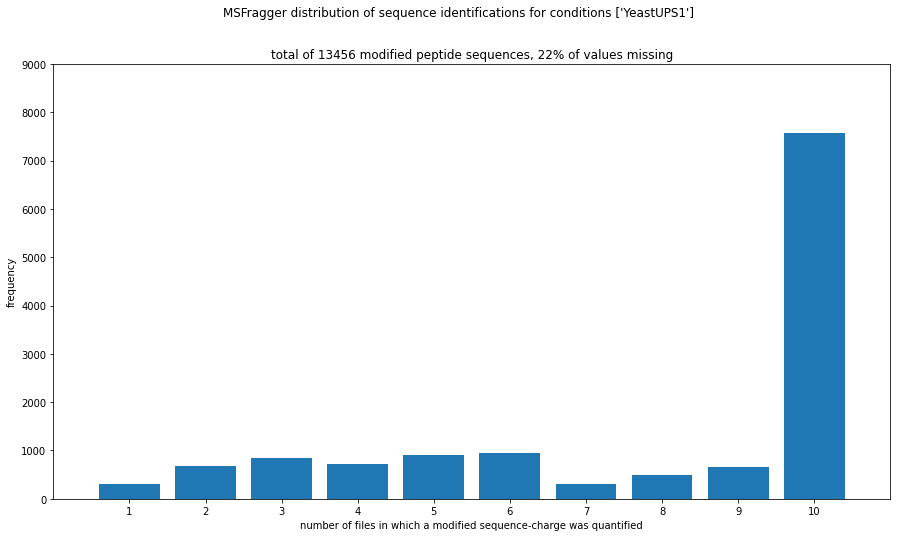

In [116]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.suptitle('MSFragger distribution of sequence identifications for conditions {}'.format(subset_groups))
plt.title('total of {} modified peptide sequences, {}% of values missing'.format(number_of_unique_sequences_fragger, int(round(fragger_missing_values*100))))

counts = np.bincount(fragger_sequence_occurences_df.number_of_runs_extracted)
ax1.bar(range(number_of_runs_in_subset+1), counts, width=0.8, align='center')
plt.xlabel('number of files in which a modified sequence-charge was quantified')
plt.ylabel('frequency')
ax1.set(xticks=range(1,number_of_runs_in_subset+1), xlim=[0, number_of_runs_in_subset+1])
plt.ylim((0,9000))

plt.show()

## distribution of quantitative intensities

#### prepare TFD/E results

In [117]:
tfde_subset_df.sample(n=3)

,sequence,charge,id_perc_q_value,protein,species,short_run_name,group,intensity,identified_in_run
13846,DSEGNAQSEEEHDLER,2,0.000028,sp|Q00816|REG1_YEAST,YEAST,YeastUPS1_07,YeastUPS1,927,False
101956,VMGSLIGDGSAGAIIDLETVHYR,3,0.000290,sp|P38348|HSM3_YEAST,YEAST,YeastUPS1_04,YeastUPS1,185,False
79322,RLFNDSALLDAK,2,0.000290,sp|P00815|HIS2_YEAST,YEAST,YeastUPS1_03,YeastUPS1,1080,True


In [118]:
# calculate the intensity mean for peptides without missing values
tfde_intensities_l = []
for group_name,group_df in tfde_subset_df.groupby(['sequence','charge'], as_index=False):
    if len(group_df.short_run_name.unique()) == number_of_runs_in_subset:
        intensity_mean = group_df.intensity.mean()
        tfde_intensities_l.append((','.join([group_name[0],group_name[1].astype('str')]),intensity_mean,'TFD/E'))
tfde_intensities_df = pd.DataFrame(tfde_intensities_l, columns=['sequence','intensity','method'])
tfde_intensities_df['intensity_adjusted'] = tfde_intensities_df.intensity - np.min(tfde_intensities_df.intensity)
tfde_intensities_df.intensity_adjusted.replace(to_replace=[0.0], value=1.0, inplace=True)

#### prepare MQ results

In [119]:
mq_subset_df.sample(n=3)

,sequence,modifications,charge,species,short_run_name,group,identified_in_file,score,intensity
18758,DSNNPALHFEWEIIHAFGK,Unmodified,3,YEAST,YeastUPS1_03,YeastUPS1,True,61.230,51246.0
126746,TKTEELQTSSMK,Unmodified,2,YEAST,YeastUPS1_10,YeastUPS1,True,117.210,30809.0
47376,GWLSEGGTLIGTAR,Unmodified,2,YEAST,YeastUPS1_02,YeastUPS1,True,67.548,18209.0


In [120]:
# calculate the intensity mean for peptides without missing values
mq_intensities_l = []
for group_name,group_df in mq_subset_df.groupby(['sequence','modifications','charge'], as_index=False):
    if len(group_df.short_run_name.unique()) == number_of_runs_in_subset:
        intensity_mean = group_df.intensity.mean()
        mq_intensities_l.append((','.join([group_name[0],group_name[1],group_name[2].astype('str')]),intensity_mean,'MaxQuant'))
mq_intensities_df = pd.DataFrame(mq_intensities_l, columns=['sequence','intensity','method'])
mq_intensities_df['intensity_adjusted'] = mq_intensities_df.intensity - np.min(mq_intensities_df.intensity)
mq_intensities_df.intensity_adjusted.replace(to_replace=[0.0], value=1.0, inplace=True)

#### prepare Fragger results

In [121]:
fragger_subset_df.sample(n=3)

,ProteinName,PeptideSequence,PrecursorCharge,FragmentIon,ProductCharge,IsotopeLabelType,Condition,BioReplicate,Run,Intensity,short_run_name,group,species
110364,sp|P31539|HS104_YEAST,AHPDVLTVMLQMLDDGR,2,NaN,NaN,L,YUPS1,5,P3830_YeastUPS1_05_Slot1-1_1_5070,86556.6200,YeastUPS1_05,YeastUPS1,YEAST
277882,sp|Q12028|AP1G1_YEAST,ASTGDNVKPIDILEEIFGEK,3,NaN,NaN,L,YUPS1,3,P3830_YeastUPS1_03_Slot1-1_1_5068,6942.6377,YeastUPS1_03,YeastUPS1,YEAST
179882,sp|P39958|GDI1_YEAST,KSDIYVAIVSDAHNVC[57.0215]SK,2,NaN,NaN,L,YUPS1,3,P3830_YeastUPS1_03_Slot1-1_1_5068,20947.6660,YeastUPS1_03,YeastUPS1,YEAST


In [122]:
# calculate the intensity mean for peptides without missing values
fragger_intensities_l = []
for group_name,group_df in fragger_subset_df.groupby(['PeptideSequence', 'PrecursorCharge'], as_index=False):
    if len(group_df['Run'].unique()) == number_of_runs_in_subset:
        intensity_mean = group_df.Intensity.mean()
        fragger_intensities_l.append((','.join([group_name[0],group_name[1].astype('str')]),intensity_mean,'MSFragger'))
fragger_intensities_df = pd.DataFrame(fragger_intensities_l, columns=['sequence','intensity','method'])
fragger_intensities_df['intensity_adjusted'] = fragger_intensities_df.intensity - np.min(fragger_intensities_df.intensity)
fragger_intensities_df.intensity_adjusted.replace(to_replace=[0.0], value=1.0, inplace=True)

In [123]:
tfde_intensities_df['intensity_log'] = np.log10(tfde_intensities_df.intensity)
mq_intensities_df['intensity_log'] = np.log10(mq_intensities_df.intensity)
fragger_intensities_df['intensity_log'] = np.log10(fragger_intensities_df.intensity)

In [124]:
tfde_intensities_df['intensity_adjusted_log'] = tfde_intensities_df.intensity_log - np.min(tfde_intensities_df.intensity_log)
mq_intensities_df['intensity_adjusted_log'] = mq_intensities_df.intensity_log - np.min(mq_intensities_df.intensity_log)
fragger_intensities_df['intensity_adjusted_log'] = fragger_intensities_df.intensity_log - np.min(fragger_intensities_df.intensity_log)

#### consolidate the data

In [125]:
intensities_l = [tfde_intensities_df,mq_intensities_df,fragger_intensities_df]
intensities_df = pd.concat(intensities_l, sort=False)

In [126]:
intensities_df.sample(n=3)

,sequence,intensity,method,intensity_adjusted,intensity_log,intensity_adjusted_log
5100,"QNEDTLLVGATDGVGTK,2",54701.2136,MSFragger,53445.01005,4.737997,1.638937
8426,"YGVIVHDIATPNLIDR,2",4738.9000,TFD/E,4550.10000,3.675678,1.399676
3957,"KLQINCVVEDDK,2",1012.4000,TFD/E,823.60000,3.005352,0.729350


#### produce the plot

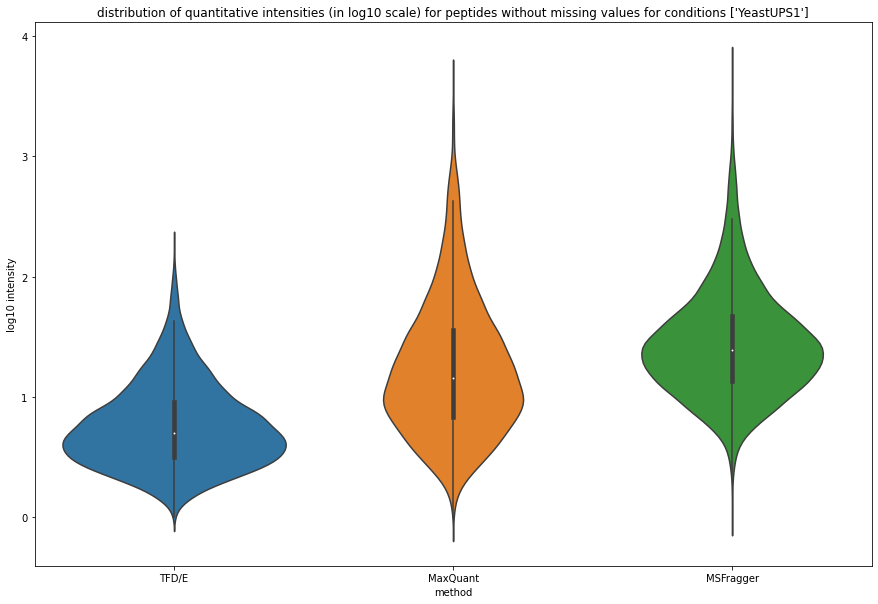

In [127]:
plt.figure(figsize=(15,10))
ax = sns.violinplot(x=intensities_df.method, y=intensities_df.intensity_adjusted_log)
_ = plt.ylabel("log10 intensity")
_ = plt.title('distribution of quantitative intensities (in log10 scale) for peptides without missing values for conditions {}'.format(subset_groups))

In [128]:
# orders of magnitude
intensities_df.groupby('method')['intensity_adjusted_log'].agg(np.ptp)

method
MSFragger    3.757624
MaxQuant     3.604313
TFD/E        2.258816
Name: intensity_adjusted_log, dtype: float64

In [129]:
# number of peptides that have no missing values
intensities_df.groupby('method')['intensity_adjusted_log'].count()

method
MSFragger    7561
MaxQuant     5754
TFD/E        8665
Name: intensity_adjusted_log, dtype: int64

## distribution of CV

#### TFD/E analysis

In [130]:
tfde_subset_df.sample(n=3)

,sequence,charge,id_perc_q_value,protein,species,short_run_name,group,intensity,identified_in_run
9523,DDQTVESYHIQDGHSVHLVK,2,0.001086,sp|P48510|DSK2_YEAST,YEAST,YeastUPS1_08,YeastUPS1,188,True
50628,KLNLILDDGGDLTTLVHEK,2,0.000028,sp|P39954|SAHH_YEAST,YEAST,YeastUPS1_06,YeastUPS1,1106,True
104975,VVNEPTAAALAYGLEK,2,0.000028,sp|P0CS90|HSP77_YEAST,YEAST,YeastUPS1_08,YeastUPS1,3889,True


In [131]:
# for each sequence, find the CV
sequence_cv_l = []
for group_name,group_df in tfde_subset_df.groupby(['sequence','charge']):
    if len(group_df) >= 2:
        intensity_cv = np.std(group_df.intensity) / np.mean(group_df.intensity)
        sequence_cv_l.append((group_name[0], group_name[1], intensity_cv))
sequence_cv_df = pd.DataFrame(sequence_cv_l, columns=['sequence','charge','intensity_cv'])

In [132]:
sequence_cv_df.sample(n=3)

,sequence,charge,intensity_cv
4426,IATTDLFLPLFFHFGSTR,3,0.371113
1806,ECPWYTGPTLLEYLDTMNHVDR,3,0.092110
3791,GVATDLSHIPTNSVVK,2,0.373840


In [133]:
sequence_cv_df[sequence_cv_df.intensity_cv > 0.25].sample(n=5)

,sequence,charge,intensity_cv
5590,KNDSDVPELATIPAAK,2,0.505483
6405,LLDEIELLLVR,2,0.288729
10231,TIM[15.9949]VNYNPETVSTDYDEADR,2,0.381244
6396,LKVPPTIAQFQYTLDR,2,0.458886
6814,LSNTNETDDER,2,0.381083


In [134]:
results_df[(results_df.sequence == 'SYSNDDESNEILSYEGK') & (results_df.charge == 2)]

,sequence,charge,identifications,extractions,identifications_d,id_perc_q_value,id_count_all_runs,id_count_human_only_runs,id_number_of_proteins,id_protein,id_species,extractions_l,ext_count_all_runs,ext_count_human_only_runs
10234,SYSNDDESNEILSYEGK,2,"{""perc_q_value"": 2.7869903e-05, ""run_names"": [...","[{""run_name"": ""P3830_YeastUPS1_01_Slot1-1_1_50...","{'perc_q_value': 2.7869903e-05, 'run_names': [...",0.000028,10,0,1,sp|P33399|LHP1_YEAST,YEAST,[{'run_name': 'P3830_YeastUPS1_01_Slot1-1_1_50...,10,0
21978,SYSNDDESNEILSYEGK,2,"{""perc_q_value"": 2.99967e-05, ""run_names"": [""P...","[{""run_name"": ""P3830_YeastUPS2_01_Slot1-1_1_50...","{'perc_q_value': 2.99967e-05, 'run_names': ['P...",0.000030,10,0,1,sp|P33399|LHP1_YEAST,YEAST,[{'run_name': 'P3830_YeastUPS2_01_Slot1-1_1_50...,10,0


In [135]:
tfde_subset_df[(tfde_subset_df.sequence == 'SYSNDDESNEILSYEGK') & (tfde_subset_df.charge == 2)]

,sequence,charge,id_perc_q_value,protein,species,short_run_name,group,intensity,identified_in_run
89263,SYSNDDESNEILSYEGK,2,0.000028,sp|P33399|LHP1_YEAST,YEAST,YeastUPS1_01,YeastUPS1,962,True
89264,SYSNDDESNEILSYEGK,2,0.000028,sp|P33399|LHP1_YEAST,YEAST,YeastUPS1_02,YeastUPS1,901,True
89265,SYSNDDESNEILSYEGK,2,0.000028,sp|P33399|LHP1_YEAST,YEAST,YeastUPS1_03,YeastUPS1,860,True
89266,SYSNDDESNEILSYEGK,2,0.000028,sp|P33399|LHP1_YEAST,YEAST,YeastUPS1_04,YeastUPS1,1264,True
89267,SYSNDDESNEILSYEGK,2,0.000028,sp|P33399|LHP1_YEAST,YEAST,YeastUPS1_05,YeastUPS1,728,True
89268,SYSNDDESNEILSYEGK,2,0.000028,sp|P33399|LHP1_YEAST,YEAST,YeastUPS1_06,YeastUPS1,829,True
89269,SYSNDDESNEILSYEGK,2,0.000028,sp|P33399|LHP1_YEAST,YEAST,YeastUPS1_07,YeastUPS1,1619,True
89270,SYSNDDESNEILSYEGK,2,0.000028,sp|P33399|LHP1_YEAST,YEAST,YeastUPS1_08,YeastUPS1,1776,True
89271,SYSNDDESNEILSYEGK,2,0.000028,sp|P33399|LHP1_YEAST,YEAST,YeastUPS1_09,YeastUPS1,2109,True
89272,SYSNDDESNEILSYEGK,2,0.000028,sp|P33399|LHP1_YEAST,YEAST,YeastUPS1_10,YeastUPS1,1701,True


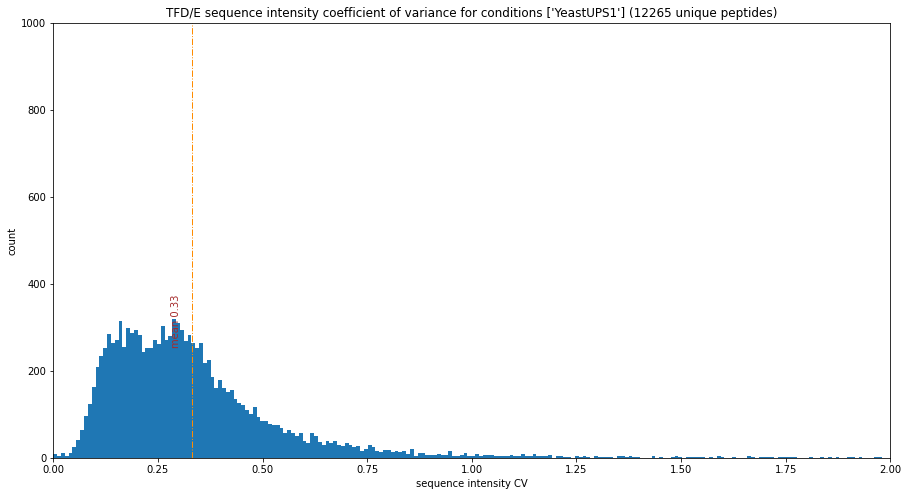

In [136]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 300
values = sequence_cv_df.intensity_cv
y, x, _ = ax1.hist(values, bins=bins)
mean = np.mean(values)
ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('sequence intensity CV')
plt.ylabel('count')
plt.title('TFD/E sequence intensity coefficient of variance for conditions {} ({} unique peptides)'.format(subset_groups,len(sequence_cv_df)))
plt.xlim((0,2))
plt.ylim((0,1000))

plt.show()

#### MQ analysis

In [137]:
# for each sequence, find the CV
sequence_cv_l = []
for group_name,group_df in mq_subset_df.groupby(['sequence','modifications','charge']):
    if len(group_df) >= 2:
        intensity_cv = np.std(group_df.intensity) / np.mean(group_df.intensity)
        sequence = ','.join([group_name[0],group_name[1],group_name[2].astype('str')])
        sequence_cv_l.append((sequence, intensity_cv))
mq_sequence_cv_df = pd.DataFrame(sequence_cv_l, columns=['sequence','intensity_cv'])

In [138]:
mq_sequence_cv_df.sample(n=3)

,sequence,intensity_cv
8927,"VINSLGVLDAIWHPR,Unmodified,2",0.387404
8608,"TWKPEDLEAVGPIASVTGK,Unmodified,2",0.055203
3381,"HQLPSNWIEAYMENPFTLIR,Unmodified,3",0.504481


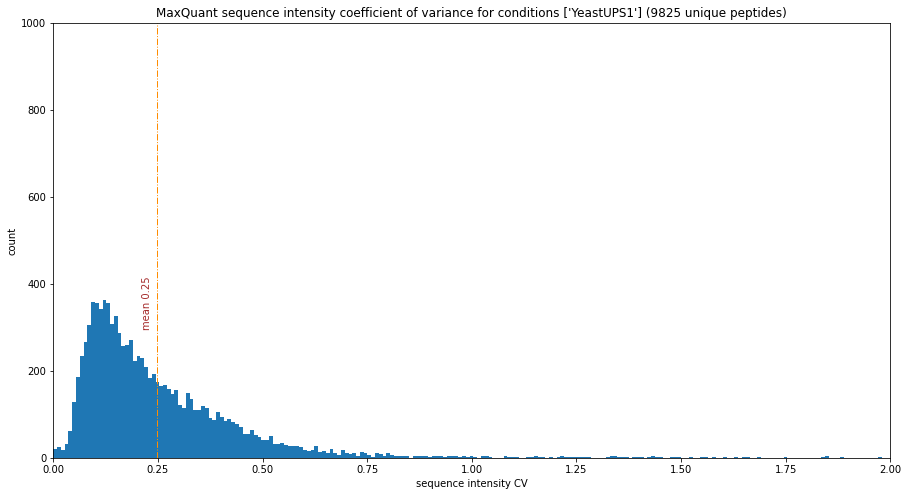

In [139]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 300
values = mq_sequence_cv_df.intensity_cv
y, x, _ = ax1.hist(values, bins=bins)
mean = np.mean(values)
ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('sequence intensity CV')
plt.ylabel('count')
plt.title('MaxQuant sequence intensity coefficient of variance for conditions {} ({} unique peptides)'.format(subset_groups, len(mq_sequence_cv_df)))
plt.xlim((0,2))
plt.ylim((0,1000))

plt.show()

#### Fragger analysis

In [140]:
# for each sequence, find the CV
sequence_cv_l = []
for group_name,group_df in fragger_subset_df.groupby(['PeptideSequence', 'PrecursorCharge']):
    if len(group_df) >= 2:
        intensity_cv = np.std(group_df.Intensity) / np.mean(group_df.Intensity)
        sequence = ','.join([group_name[0],group_name[1].astype('str')])
        sequence_cv_l.append((sequence, intensity_cv))
fragger_sequence_cv_df = pd.DataFrame(sequence_cv_l, columns=['sequence','intensity_cv'])

In [141]:
fragger_sequence_cv_df.sample(n=3)

,sequence,intensity_cv
11983,"VPTVIGEAITHINTLFDDR,3",0.596009
7214,"LQINC[57.0215]VVEDDKVSLDDLQQSIEEDEDHVQSTDIAAMQK,3",0.129440
1511,"DMNSETFQIEQDHASK,2",0.288577


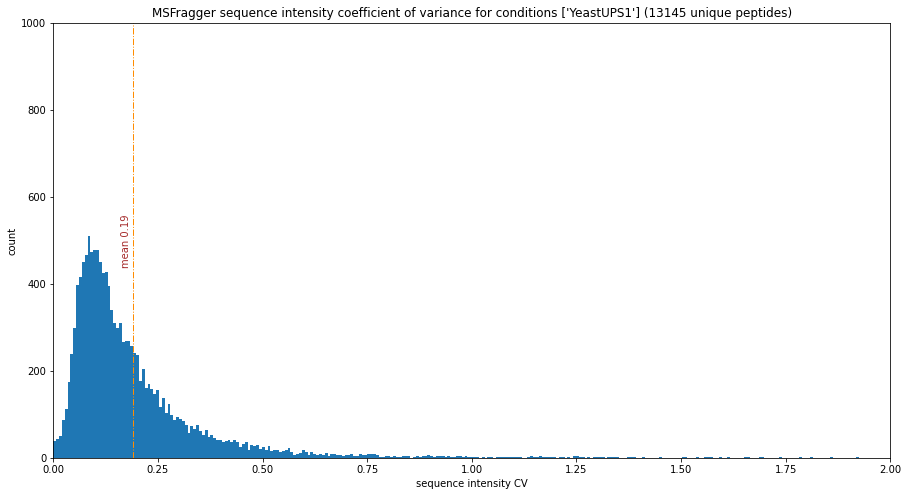

In [142]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 300
values = fragger_sequence_cv_df.intensity_cv
y, x, _ = ax1.hist(values, bins=bins)
mean = np.mean(values)
ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('sequence intensity CV')
plt.ylabel('count')
plt.title('MSFragger sequence intensity coefficient of variance for conditions {} ({} unique peptides)'.format(subset_groups,len(fragger_sequence_cv_df)))
plt.xlim((0,2))
plt.ylim((0,1000))

plt.show()

## comparison of peptide intensity in different experiment conditions

In [165]:
# the experiment conditions to compare
groupA = 'YeastUPS1'
groupA_number_of_runs = 10
groupB = 'YeastUPS2'
groupB_number_of_runs = 10

#### TFD/E analysis

In [166]:
sequences_df.columns

Index(['sequence', 'charge', 'id_perc_q_value', 'protein', 'species',
       'short_run_name', 'group', 'intensity', 'identified_in_run'],
      dtype='object')

In [167]:
sequences_df.identified_in_run.sum()

146442

In [168]:
len(sequences_df[sequences_df.identified_in_run == True])

146442

In [169]:
# for each sequence and charge, if it was found in more than half the runs, 
# find the mean intensity in each group, then find the intensity ratio between groups
sequence_occurences_in_group = []
for group_name,group_df in sequences_df.groupby(['sequence','charge'], as_index=False):
    sequence_in_A_df = group_df[group_df.group == groupA]
    sequence_in_B_df = group_df[group_df.group == groupB]
    if (
            (sequence_in_A_df.identified_in_run.sum() > 0) and            # must have at least one ID in the group
            (sequence_in_B_df.identified_in_run.sum() > 0) and
            (len(sequence_in_A_df) >= int(groupA_number_of_runs / 2)) and # must have been extracted from more than half the runs in the group
            (len(sequence_in_B_df) >= int(groupB_number_of_runs / 2))
            ):
        intensity_A = sequence_in_A_df.intensity.mean()
        intensity_B = sequence_in_B_df.intensity.mean()
        species = group_df.iloc[0].species
        sequence = group_name[0]
        charge = group_name[1]
        sequence_occurences_in_group.append((sequence, charge, species, intensity_A, intensity_B))

In [170]:
sequence_occurences_in_group_df = pd.DataFrame(sequence_occurences_in_group, columns=['sequence','charge','species','intensity_A','intensity_B'])

In [171]:
sequence_occurences_in_group_df['intensity_ratio'] = sequence_occurences_in_group_df.intensity_B / sequence_occurences_in_group_df.intensity_A

In [172]:
sequence_occurences_in_group_df['intensity_ratio_log'] = np.log2(sequence_occurences_in_group_df['intensity_ratio'])

#### plot the intensity ratios of the two proteomes

In [173]:
human_df = sequence_occurences_in_group_df[sequence_occurences_in_group_df.species == 'HUMAN']
yeast_df = sequence_occurences_in_group_df[sequence_occurences_in_group_df.species == 'YEAST']

In [174]:
max_tfde = max(np.log2(sequence_occurences_in_group_df.intensity_A).max(), np.log2(sequence_occurences_in_group_df.intensity_B).max())
min_tfde = min(np.log2(sequence_occurences_in_group_df.intensity_A).min(), np.log2(sequence_occurences_in_group_df.intensity_B).min())
max_tfde, min_tfde

(15.064338591882816, 6.362570079384708)

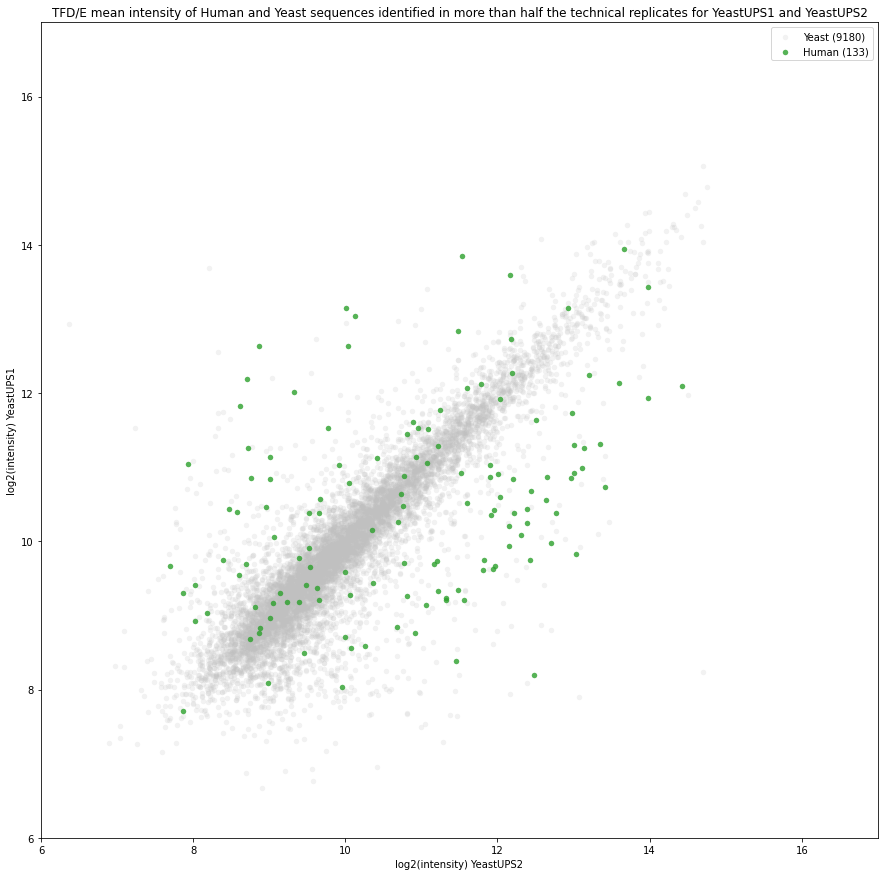

In [175]:
f, ax = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)
plt.margins(0.06)

title = 'TFD/E mean intensity of Human and Yeast sequences identified in more than half the technical replicates for {} and {}'.format(groupA, groupB)
plt.title(title)

ax.scatter(np.log2(yeast_df.intensity_B), np.log2(yeast_df.intensity_A), marker='o', color='silver', lw=0, s=30, alpha=0.2, label="Yeast ({})".format(len(yeast_df)))
ax.scatter(np.log2(human_df.intensity_B), np.log2(human_df.intensity_A), marker='o', color='tab:green', lw=0, s=30, alpha=0.8, label="Human ({})".format(len(human_df)))

plt.legend(loc='best')
plt.xlabel('log2(intensity) {}'.format(groupB))
plt.ylabel('log2(intensity) {}'.format(groupA))

plt.xlim((6,17))
plt.ylim((6,17))

plt.show()

/home/daryl/anaconda3/envs/py36/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/daryl/anaconda3/envs/py36/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


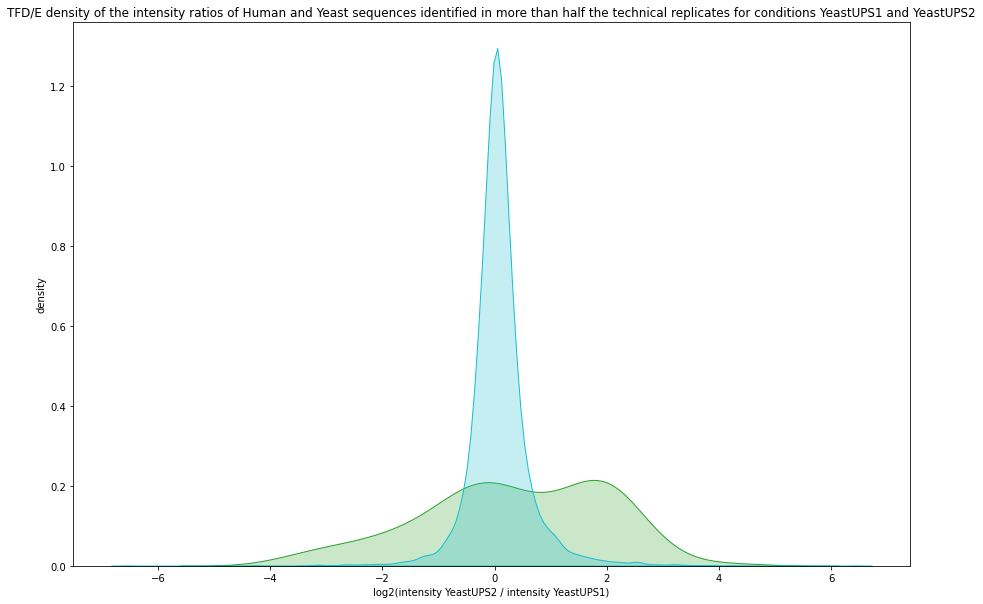

In [176]:
import seaborn as sns
plt.figure(figsize=(15, 10))

title = 'TFD/E density of the intensity ratios of Human and Yeast sequences identified in more than half the technical replicates for conditions {} and {}'.format(groupA, groupB)
plt.title(title)

# plt.xlim((-4,4))
# plt.ylim((0,1))

ax = sns.distplot(np.log2(human_df['intensity_ratio']), hist = False, color='tab:green', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'Human')
_ = sns.distplot(np.log2(yeast_df['intensity_ratio']), hist = False, color='tab:cyan', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'Yeast')

# x = ax.lines[0].get_xdata()
# y = ax.lines[0].get_ydata()
# plt.axvline(x[np.argmax(y)], color='green', lw=0.5, ls='-.')

# x = ax.lines[1].get_xdata()
# y = ax.lines[1].get_ydata()
# plt.axvline(x[np.argmax(y)], color='red', lw=0.5, ls='-.')

_ = ax.set(xlabel='log2(intensity {} / intensity {})'.format(groupB, groupA), ylabel='density')


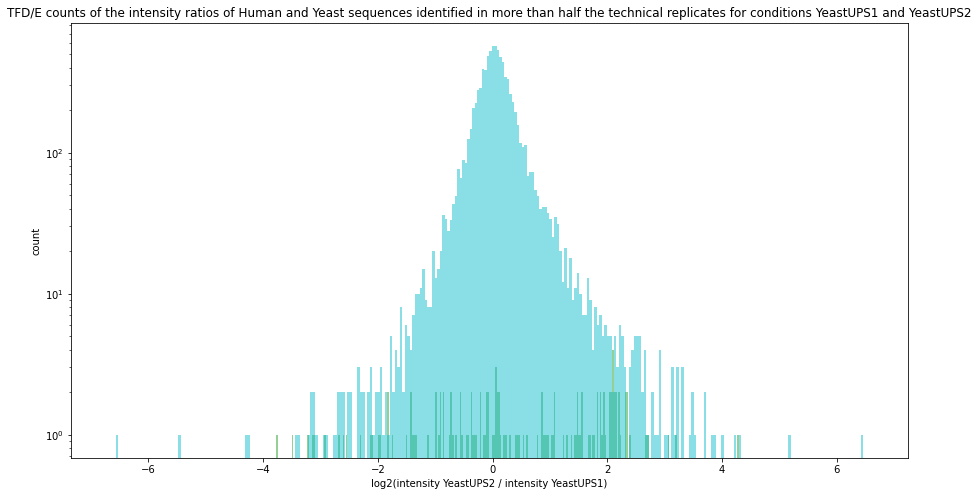

In [177]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

title = 'TFD/E counts of the intensity ratios of Human and Yeast sequences identified in more than half the technical replicates for conditions {} and {}'.format(groupA, groupB)
plt.margins(0.06)
plt.title(title)

bins = 300
y, x, _ = ax1.hist(np.log2(human_df['intensity_ratio']), bins=bins, color='tab:green', alpha=0.5)
y, x, _ = ax1.hist(np.log2(yeast_df['intensity_ratio']), bins=bins, color='tab:cyan', alpha=0.5)

plt.xlabel('log2(intensity {} / intensity {})'.format(groupB, groupA))
plt.ylabel('count')
# plt.xlim((0,2))
# plt.ylim((0,60))
plt.yscale('log', basey=10, nonposy='clip')

plt.show()

#### MQ analysis

In [178]:
mq_sequences_df.columns

Index(['sequence', 'modifications', 'charge', 'species', 'short_run_name',
       'group', 'identified_in_file', 'score', 'intensity'],
      dtype='object')

In [179]:
# for each sequence and charge, if it was found in more than half the runs, 
# find the mean intensity in each group, then find the intensity ratio between groups
sequence_occurences_in_group = []
for group_name,group_df in mq_sequences_df.groupby(['sequence','modifications','charge'], as_index=False):
    sequence_in_A_df = group_df[group_df.group == groupA]
    sequence_in_B_df = group_df[group_df.group == groupB]
    if (len(sequence_in_A_df) >= int(groupA_number_of_runs / 2)) and (len(sequence_in_B_df) >= int(groupB_number_of_runs / 2)):
        average_intensity_in_A = sequence_in_A_df.intensity.mean()
        average_intensity_in_B = sequence_in_B_df.intensity.mean()
        species = group_df.iloc[0].species
        sequence = group_name[0]
        charge = group_name[1]
        sequence_occurences_in_group.append((sequence, charge, species, average_intensity_in_A, average_intensity_in_B))

In [180]:
mq_sequence_occurences_in_group_df = pd.DataFrame(sequence_occurences_in_group, columns=['sequence','charge','species','intensity_A','intensity_B'])

In [181]:
mq_sequence_occurences_in_group_df['intensity_ratio'] = mq_sequence_occurences_in_group_df.intensity_B / mq_sequence_occurences_in_group_df.intensity_A

In [182]:
human_df = mq_sequence_occurences_in_group_df[mq_sequence_occurences_in_group_df.species == 'HUMAN']
yeast_df = mq_sequence_occurences_in_group_df[mq_sequence_occurences_in_group_df.species == 'YEAST']


In [183]:
max_mq = max(np.log2(mq_sequence_occurences_in_group_df.intensity_A).max(), np.log2(mq_sequence_occurences_in_group_df.intensity_B).max())
min_mq = min(np.log2(mq_sequence_occurences_in_group_df.intensity_A).min(), np.log2(mq_sequence_occurences_in_group_df.intensity_B).min())
max_mq, min_mq

(24.308789513113034, 11.29018016164021)

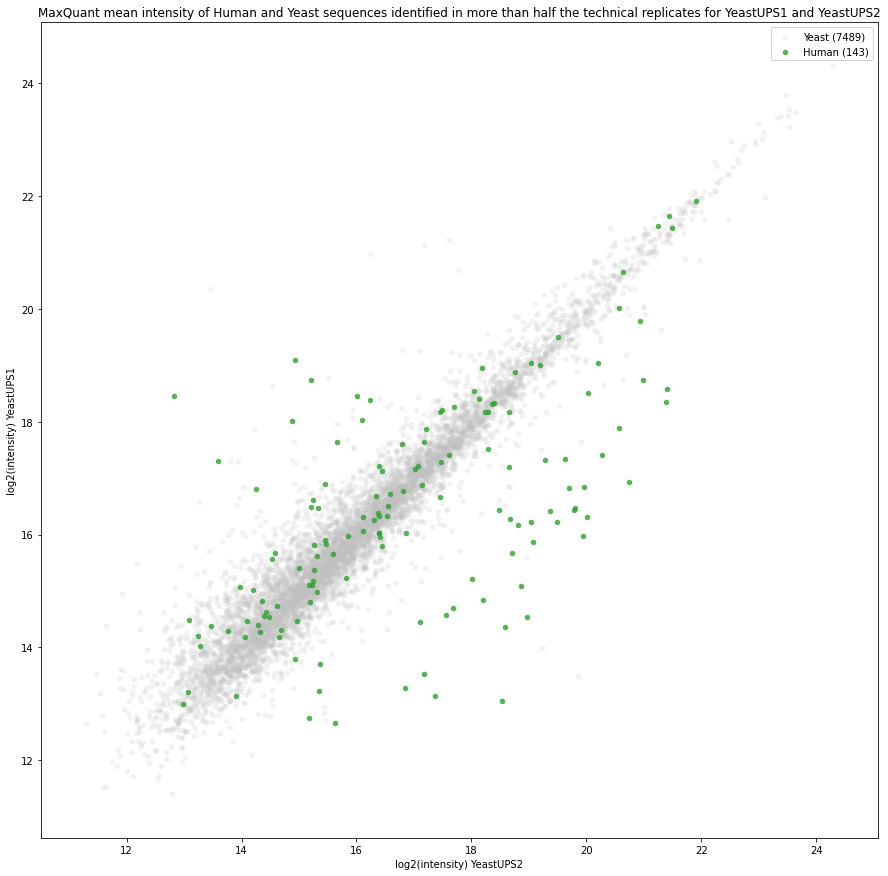

In [184]:
f, ax = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)
plt.margins(0.06)

title = 'MaxQuant mean intensity of Human and Yeast sequences identified in more than half the technical replicates for {} and {}'.format(groupA, groupB)
plt.title(title)

ax.scatter(np.log2(yeast_df.intensity_B), np.log2(yeast_df.intensity_A), marker='o', color='silver', lw=0, s=30, alpha=0.2, label="Yeast ({})".format(len(yeast_df)))
ax.scatter(np.log2(human_df.intensity_B), np.log2(human_df.intensity_A), marker='o', color='tab:green', lw=0, s=30, alpha=0.8, label="Human ({})".format(len(human_df)))

plt.legend(loc='best')
plt.xlabel('log2(intensity) {}'.format(groupB))
plt.ylabel('log2(intensity) {}'.format(groupA))

# plt.xlim((7,24))
# plt.ylim((7,24))

plt.show()

/home/daryl/anaconda3/envs/py36/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/daryl/anaconda3/envs/py36/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


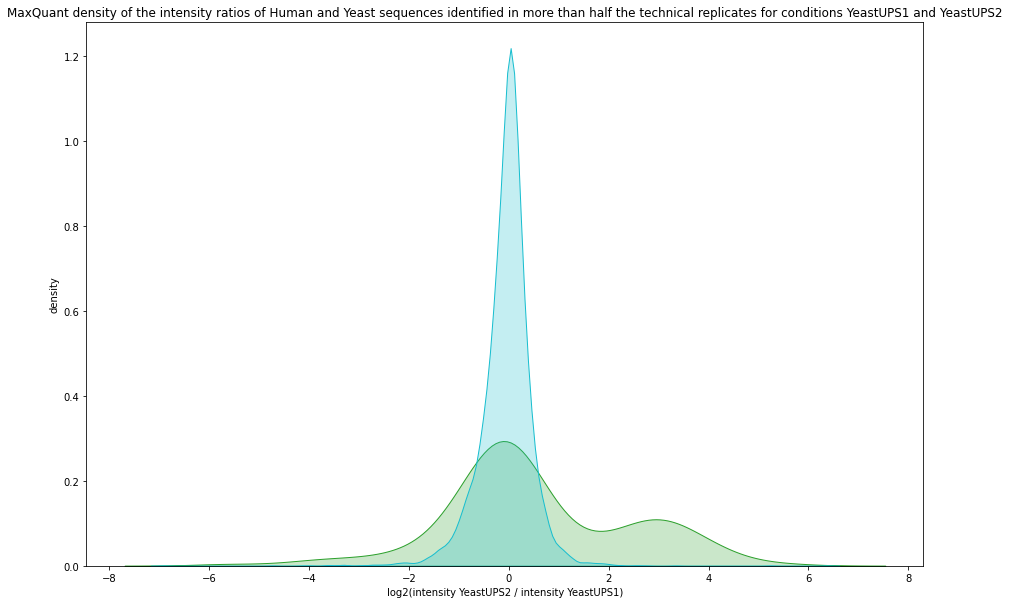

In [185]:
import seaborn as sns
plt.figure(figsize=(15, 10))

title = 'MaxQuant density of the intensity ratios of Human and Yeast sequences identified in more than half the technical replicates for conditions {} and {}'.format(groupA, groupB)
plt.title(title)

# plt.xlim((-4,4))
# plt.ylim((0,1))

ax = sns.distplot(np.log2(human_df['intensity_ratio']), hist = False, color='tab:green', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'Human')
_ = sns.distplot(np.log2(yeast_df['intensity_ratio']), hist = False, color='tab:cyan', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'Yeast')

# x = ax.lines[0].get_xdata()
# y = ax.lines[0].get_ydata()
# plt.axvline(x[np.argmax(y)], color='green', lw=0.5, ls='-.')

# x = ax.lines[1].get_xdata()
# y = ax.lines[1].get_ydata()
# plt.axvline(x[np.argmax(y)], color='red', lw=0.5, ls='-.')

_ = ax.set(xlabel='log2(intensity {} / intensity {})'.format(groupB, groupA), ylabel='density')


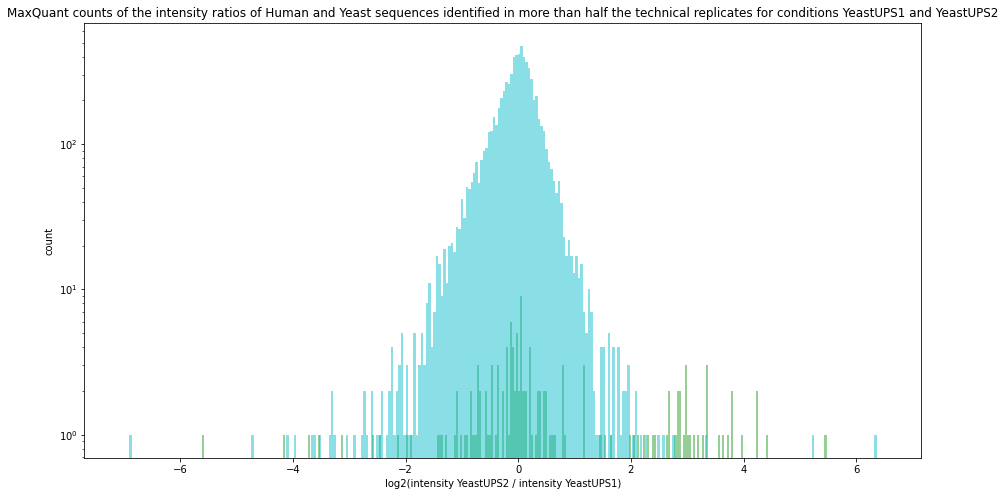

In [186]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

title = 'MaxQuant counts of the intensity ratios of Human and Yeast sequences identified in more than half the technical replicates for conditions {} and {}'.format(groupA, groupB)
plt.margins(0.06)
plt.title(title)

bins = 300
y, x, _ = ax1.hist(np.log2(human_df['intensity_ratio']), bins=bins, color='tab:green', alpha=0.5)
y, x, _ = ax1.hist(np.log2(yeast_df['intensity_ratio']), bins=bins, color='tab:cyan', alpha=0.5)

plt.xlabel('log2(intensity {} / intensity {})'.format(groupB, groupA))
plt.ylabel('count')
# plt.xlim((0,2))
# plt.ylim((0,60))
plt.yscale('log', basey=10, nonposy='clip')

plt.show()

#### Fragger analysis

In [187]:
fragger_sequences_df.columns

Index(['ProteinName', 'PeptideSequence', 'PrecursorCharge', 'FragmentIon',
       'ProductCharge', 'IsotopeLabelType', 'Condition', 'BioReplicate', 'Run',
       'Intensity', 'short_run_name', 'group', 'species'],
      dtype='object')

In [188]:
# for each sequence and charge, if it was found in more than half the runs, 
# find the mean intensity in each group, then find the intensity ratio between groups
sequence_occurences_in_group = []
for group_name,group_df in fragger_sequences_df.groupby(['PeptideSequence','PrecursorCharge'], as_index=False):
    sequence_in_A_df = group_df[group_df.group == groupA]
    sequence_in_B_df = group_df[group_df.group == groupB]
    if (len(sequence_in_A_df) >= int(groupA_number_of_runs / 2)) and (len(sequence_in_B_df) >= int(groupB_number_of_runs / 2)):
        average_intensity_in_A = sequence_in_A_df.Intensity.mean()
        average_intensity_in_B = sequence_in_B_df.Intensity.mean()
        species = group_df.iloc[0].species
        sequence = group_name[0]
        charge = group_name[1]
        sequence_occurences_in_group.append((sequence, charge, species, average_intensity_in_A, average_intensity_in_B))

In [189]:
fragger_sequence_occurences_in_group_df = pd.DataFrame(sequence_occurences_in_group, columns=['sequence','charge','species','intensity_A','intensity_B'])

In [190]:
fragger_sequence_occurences_in_group_df['intensity_ratio'] = fragger_sequence_occurences_in_group_df.intensity_B / fragger_sequence_occurences_in_group_df.intensity_A

In [191]:
human_df = fragger_sequence_occurences_in_group_df[fragger_sequence_occurences_in_group_df.species == 'HUMAN']
yeast_df = fragger_sequence_occurences_in_group_df[fragger_sequence_occurences_in_group_df.species == 'YEAST']

In [192]:
max_fragger = max(np.log2(fragger_sequence_occurences_in_group_df.intensity_A).max(), np.log2(fragger_sequence_occurences_in_group_df.intensity_B).max())
min_fragger = min(np.log2(fragger_sequence_occurences_in_group_df.intensity_A).min(), np.log2(fragger_sequence_occurences_in_group_df.intensity_B).min())
max_fragger, min_fragger

(22.963667816354604, 8.452135397721593)

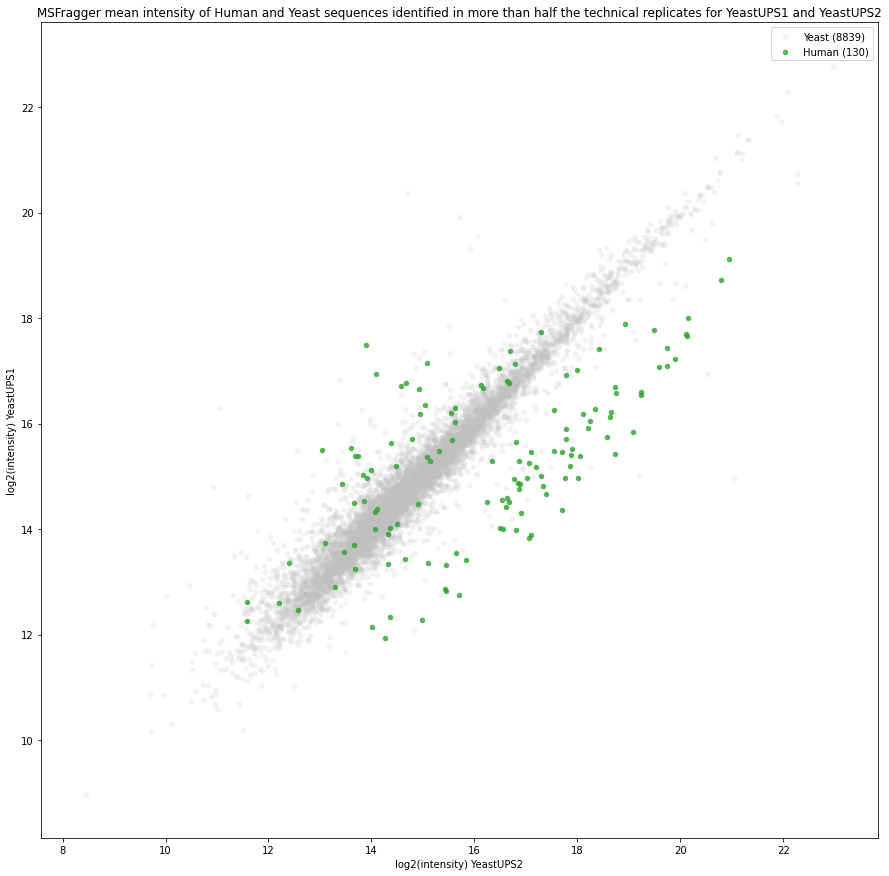

In [193]:
f, ax = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)
plt.margins(0.06)

title = 'MSFragger mean intensity of Human and Yeast sequences identified in more than half the technical replicates for {} and {}'.format(groupA, groupB)
plt.title(title)

ax.scatter(np.log2(yeast_df.intensity_B), np.log2(yeast_df.intensity_A), marker='o', color='silver', lw=0, s=30, alpha=0.2, label="Yeast ({})".format(len(yeast_df)))
ax.scatter(np.log2(human_df.intensity_B), np.log2(human_df.intensity_A), marker='o', color='tab:green', lw=0, s=30, alpha=0.8, label="Human ({})".format(len(human_df)))

plt.legend(loc='best')
plt.xlabel('log2(intensity) {}'.format(groupB))
plt.ylabel('log2(intensity) {}'.format(groupA))

# plt.xlim((7,24))
# plt.ylim((7,24))

plt.show()

/home/daryl/anaconda3/envs/py36/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/daryl/anaconda3/envs/py36/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


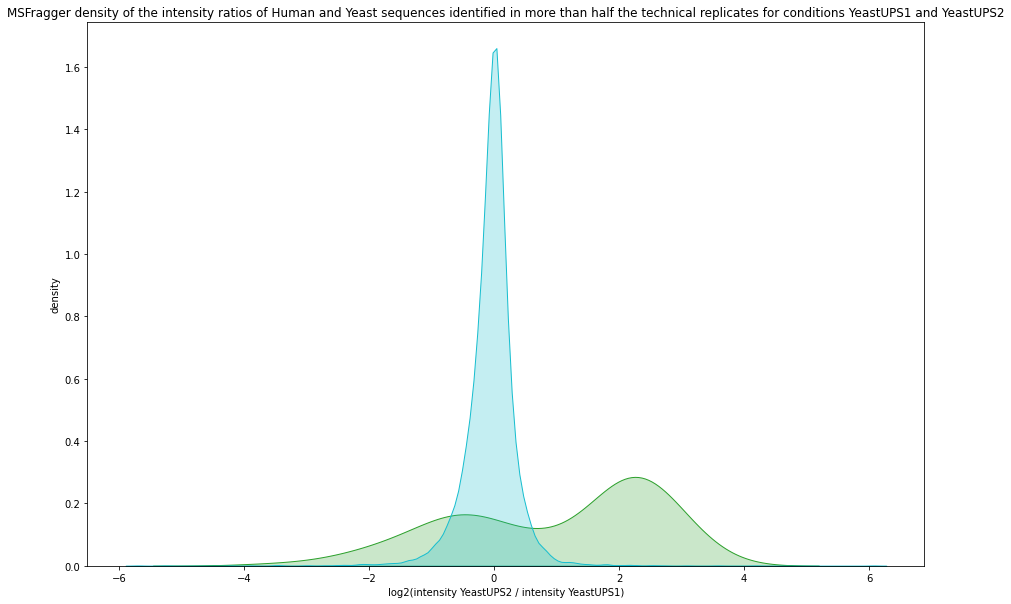

In [194]:
import seaborn as sns
plt.figure(figsize=(15, 10))

title = 'MSFragger density of the intensity ratios of Human and Yeast sequences identified in more than half the technical replicates for conditions {} and {}'.format(groupA, groupB)
plt.title(title)

# plt.xlim((-4,4))
# plt.ylim((0,1))

ax = sns.distplot(np.log2(human_df['intensity_ratio']), hist = False, color='tab:green', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'Human')
_ = sns.distplot(np.log2(yeast_df['intensity_ratio']), hist = False, color='tab:cyan', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'Yeast')

# x = ax.lines[0].get_xdata()
# y = ax.lines[0].get_ydata()
# plt.axvline(x[np.argmax(y)], color='green', lw=0.5, ls='-.')

# x = ax.lines[1].get_xdata()
# y = ax.lines[1].get_ydata()
# plt.axvline(x[np.argmax(y)], color='red', lw=0.5, ls='-.')

_ = ax.set(xlabel='log2(intensity {} / intensity {})'.format(groupB, groupA), ylabel='density')


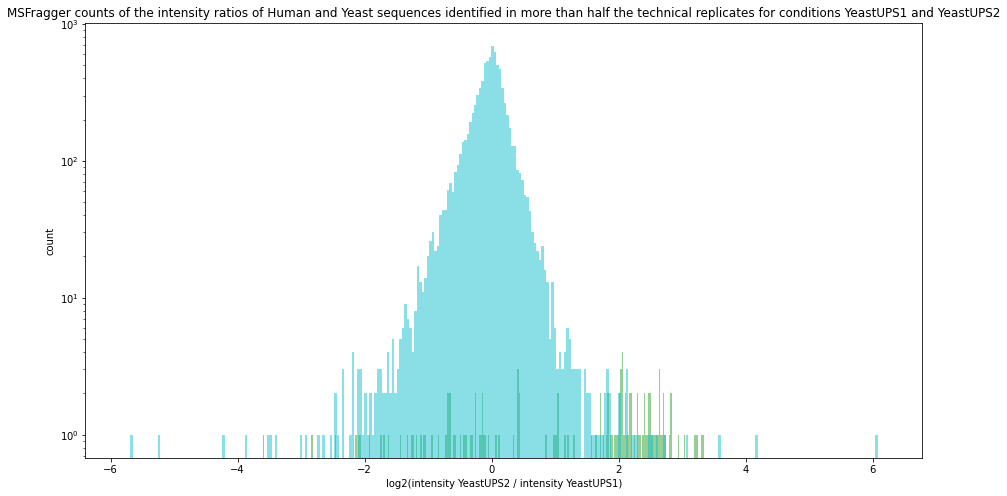

In [195]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

title = 'MSFragger counts of the intensity ratios of Human and Yeast sequences identified in more than half the technical replicates for conditions {} and {}'.format(groupA, groupB)
plt.margins(0.06)
plt.title(title)

bins = 300
y, x, _ = ax1.hist(np.log2(human_df['intensity_ratio']), bins=bins, color='tab:green', alpha=0.5)
y, x, _ = ax1.hist(np.log2(yeast_df['intensity_ratio']), bins=bins, color='tab:cyan', alpha=0.5)

plt.xlabel('log2(intensity {} / intensity {})'.format(groupB, groupA))
plt.ylabel('count')
# plt.xlim((0,2))
# plt.ylim((0,60))
plt.yscale('log', basey=10, nonposy='clip')

plt.show()

In [196]:
max(max_tfde, max_mq, max_fragger), min(min_tfde, min_mq, min_fragger)

(24.308789513113034, 6.362570079384708)